<a href="https://colab.research.google.com/github/fmuranda/Climate_Science./blob/main/Ocean_Acidification_project_notebook_Copy1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install cartopy

In [ ]:
import os
import xarray as xr
from pooch import retrieve
from collections import defaultdict
from requests.exceptions import ReadTimeout
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
!pip install cartopy
import cartopy

# Functions

These functions will help you handle the data. You don't need to play with them.

In [ ]:
def download_OCADS_data(variables, scenarios):
    """
    Download multiple variables and scenarios from OCADS.

    Usage:
        data = download_OCADS_data(['pHT', 'Temperature'], ['historical', 'ssp585'])

    Returns:
        Nested dictionary of xarray.DataArray objects structured as:
            data[variable][scenario] → DataArray

    Available variables:
        - Aragonite
        - CO3
        - Calcite
        - DIC
        - H
        - Hfree
        - RF
        - Salinity
        - TA
        - Temperature
        - fCO2
        - pCO2
        - pHT

    Available scenarios:
        - historical
        - ssp119
        - ssp126
        - ssp245
        - ssp370
        - ssp585
    """
    def pooch_load(url, filename):
        return retrieve(url=url, known_hash=None, fname=filename)

    # Normalize inputs
    if isinstance(variables, str):
        variables = [variables]
    if isinstance(scenarios, str):
        scenarios = [scenarios]

    available_variables = [
        "Aragonite", "CO3", "Calcite", "DIC", "H", "Hfree", "RF",
        "Salinity", "TA", "Temperature", "fCO2", "pCO2", "pHT"
    ]
    available_scenarios = [
        "historical", "ssp119", "ssp126", "ssp245", "ssp370", "ssp585"
    ]

    for var in variables:
        if var not in available_variables:
            raise ValueError(f"{var} not recognized. Choose from: {available_variables}")
    for scen in scenarios:
        if scen not in available_scenarios:
            raise ValueError(f"{scen} not recognized. Choose from: {available_scenarios}")

    variable_name_map = {
        "Temperature": "temperature"
        # add more mappings here if needed
    }

    base_url = "https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0259391/nc/median/"
    output = {}

    for var in variables:
        output[var] = {}
        for scen in scenarios:
            filename = f"{var}_median_{scen}.nc"
            url = f"{base_url}{filename}"
            try:
                print(f"Downloading {filename}…")
                ds = xr.open_dataset(pooch_load(url, filename))
            except ReadTimeout:
                print(f"Download timed out, trying OSF mirror for {filename}…")
                osf_link_id = "ac7zg"
                mirror_url = f"https://osf.io/download/{osf_link_id}/"
                ds = xr.open_dataset(pooch_load(mirror_url, filename))

            actual_var_name = variable_name_map.get(var, var)
            output[var][scen] = ds[actual_var_name]

    return output

In [ ]:
def save_OCADS_data(output, output_dir):
    """
    Save each variable–scenario DataArray to a NetCDF file in the specified directory.

    Parameters:
        output (dict): Dictionary structured as output[variable][scenario] = DataArray
        output_dir (str): Path to the directory where files will be saved
    """
    os.makedirs(output_dir, exist_ok=True)

    for var, scen_dict in output.items():
        for scen, data_array in scen_dict.items():
            filename = f"{var}_{scen}.nc"
            filepath = os.path.join(output_dir, filename)
            print(f"Saving {filepath}...")
            # Convert DataArray to Dataset if needed for better metadata
            if isinstance(data_array, xr.DataArray):
                data_array = data_array.to_dataset(name=var)
            data_array.to_netcdf(filepath)

In [ ]:

def load_OCADS_data(directory="./"):
    """
    Load NetCDF files saved in `directory` into a nested dictionary of the form:
        output[variable][scenario] = xarray.DataArray

    Assumes files are named like: VARIABLE_SCENARIO.nc (e.g., pHT_historical.nc)

    Parameters:
        directory (str): Directory to search for NetCDF files.

    Returns:
        dict: Nested dictionary with structure [variable][scenario] = DataArray
    """
    output = defaultdict(dict)

    for fname in os.listdir(directory):
        if fname.endswith(".nc"):
            # Parse variable and scenario from filename
            base = os.path.splitext(fname)[0]  # Remove .nc
            try:
                var, scen = base.rsplit("_", 1)
            except ValueError:
                print(f"Skipping file with unexpected name: {fname}")
                continue
            path = os.path.join(directory, fname)
            ds = xr.open_dataset(path)
            if var in ds:
                output[var][scen] = ds[var]
            else:
                # fallback to the first variable if name not found explicitly
                output[var][scen] = next(iter(ds.data_vars.values()))

    return dict(output)

In [ ]:
def combine_variables_per_scenario(output):
    """
    Combine variables for each scenario into a single xarray.Dataset.

    Parameters:
        output (dict): Nested dictionary structured as output[variable][scenario] = DataArray

    Returns:
        dict: Dictionary with keys = scenario names, values = xarray.Dataset containing all variables
    """
    combined = {}

    # Get all unique scenarios from any variable
    scenarios = set(s for var in output for s in output[var])

    for scenario in scenarios:
        vars_for_scenario = {
            var: output[var][scenario]
            for var in output
            if scenario in output[var]
        }
        if vars_for_scenario:
            combined[scenario] = xr.Dataset(vars_for_scenario)

    return combined

In [ ]:
def concat_historical_with_ssp(combined_scenarios, ssp_scenario):
    """
    Concatenate the 'historical' and given SSP scenario Datasets along time.

    Parameters:
        combined_scenarios (dict): Output of combine_variables_per_scenario()
        ssp_scenario (str): Scenario to append to historical (e.g., 'ssp245', 'ssp585')

    Returns:
        xarray.Dataset: Combined Dataset with 'historical' followed by SSP scenario.
    """
    if 'historical' not in combined_scenarios:
        raise ValueError("Historical data not found in combined_scenarios")
    if ssp_scenario not in combined_scenarios:
        raise ValueError(f"Scenario '{ssp_scenario}' not found in combined_scenarios")

    return xr.concat(
        [combined_scenarios['historical'], combined_scenarios[ssp_scenario]],
        dim='time'
    )

In [ ]:
import xarray as xr
import numpy as np

def fix_lat_lon(ds: xr.Dataset, lon_offset: float = 20) -> xr.Dataset:
    """
    Fixes latitude and longitude coordinates in an xarray.Dataset:
      - Converts lat from [0, 180] to [-90, 90]
      - Converts lon from [0, 360] to [-180, 180]
      - Applies optional longitude offset (degrees)
      - Promotes lat/lon to coordinates if they're only dimensions
      - Sorts lat ascending (south to north) and lon ascending (west to east)

    Parameters:
        ds (xr.Dataset): Dataset with 'lat' and 'lon' dimensions to fix.
        lon_offset (float): Degrees to shift longitude after [-180,180] conversion.
                            Positive shifts east, negative shifts west.

    Returns:
        xr.Dataset: Dataset with corrected lat/lon coordinates.
    """
    # Promote lat/lon to coordinates if necessary
    if 'lat' not in ds.coords:
        ds = ds.assign_coords(lat=np.arange(ds.dims['lat']))
    if 'lon' not in ds.coords:
        ds = ds.assign_coords(lon=np.arange(ds.dims['lon']))

    # Shift latitude from 0–180 to -90–90
    ds = ds.assign_coords(lat=ds['lat'] - 90)

    # Shift longitude from 0–360 to -180–180
    lon = ds['lon']
    lon = ((lon + 180) % 360) - 180  # shift to [-180, 180)

    # Apply the offset and wrap again to [-180,180)
    lon = ((lon + lon_offset + 180) % 360) - 180

    ds = ds.assign_coords(lon=lon)

    # Sort longitudes and latitudes to ensure proper order
    ds = ds.sortby(['lat', 'lon'])

    return ds

In [ ]:
def fix_all_datasets(data_dict, lon_offset=20, save_dir='./'):
    """
    Applies fix_lat_lon to every DataArray in the nested dict and saves them.

    Parameters:
        data_dict (dict): Nested dict {variable: {scenario: DataArray}}
        lon_offset (float): Degrees to shift longitude.
        save_dir (str): Directory to save fixed datasets.
    """
    import os
    import xarray as xr

    os.makedirs(save_dir, exist_ok=True)

    for var, scen_dict in data_dict.items():
        for scen, da in scen_dict.items():
            print(f"Fixing {var} - {scen}")
            # Convert DataArray to Dataset so fix_lat_lon can work properly
            ds = da.to_dataset(name=var)
            ds_fixed = fix_lat_lon(ds, lon_offset=lon_offset)

            # Save fixed dataset to NetCDF
            filename = f"{var}_{scen}.nc"
            filepath = os.path.join(save_dir, filename)
            print(f"Saving fixed dataset to {filepath}")
            ds_fixed.to_netcdf(filepath)

# Downloading the Data

You only need to do this once, unless you need more data

In [ ]:
data = download_OCADS_data(variables=["pHT", "fCO2"], scenarios = ["historical", "ssp119", "ssp245", "ssp585"])

In [ ]:
data

{'pHT': {'historical': <xarray.DataArray 'pHT' (time: 18, lat: 180, lon: 360)> Size: 9MB
  [1166400 values with dtype=float64]
  Coordinates:
    * time     (time) float64 144B 1.75e+03 1.85e+03 1.86e+03 ... 2e+03 2.01e+03
  Dimensions without coordinates: lat, lon
  Attributes:
      long name:  pH on total hydrogen ion scale
      CF_name:    sea_water_ph_reported_on_total_scale
      units:      N/A,
  'ssp119': <xarray.DataArray 'pHT' (time: 9, lat: 180, lon: 360)> Size: 5MB
  [583200 values with dtype=float64]
  Coordinates:
    * time     (time) float64 72B 2.02e+03 2.03e+03 2.04e+03 ... 2.09e+03 2.1e+03
  Dimensions without coordinates: lat, lon
  Attributes:
      long name:  pH on total hydrogen ion scale
      CF_name:    sea_water_ph_reported_on_total_scale
      units:      N/A,
  'ssp245': <xarray.DataArray 'pHT' (time: 9, lat: 180, lon: 360)> Size: 5MB
  [583200 values with dtype=float64]
  Coordinates:
    * time     (time) float64 72B 2.02e+03 2.03e+03 2.04e+03 ... 2.09

In [ ]:
data["pHT"]["historical"]

<xarray.DataArray 'pHT' (time: 18, lat: 180, lon: 360)> Size: 9MB
[1166400 values with dtype=float64]
Coordinates:
  * time     (time) float64 144B 1.75e+03 1.85e+03 1.86e+03 ... 2e+03 2.01e+03
Dimensions without coordinates: lat, lon
Attributes:
    long name:  pH on total hydrogen ion scale
    CF_name:    sea_water_ph_reported_on_total_scale
    units:      N/A

After downloading, you can save it to the server for easy access later, that way you don't need to donwload from NOAA every single time you run the notebook.

In [ ]:
save_OCADS_data(output=data, output_dir='.')

Saving ./pHT_historical.nc...
Saving ./pHT_ssp119.nc...
Saving ./pHT_ssp245.nc...
Saving ./pHT_ssp585.nc...
Saving ./fCO2_historical.nc...
Saving ./fCO2_ssp119.nc...
Saving ./fCO2_ssp245.nc...
Saving ./fCO2_ssp585.nc...


You can open the data from the Juypter Hub using the function below wihtout changing it. This is the reccomended way of opening the data every day.

In [ ]:
data = load_OCADS_data("./")

In [ ]:
data

{'pHT': {'ssp245': <xarray.DataArray 'pHT' (time: 9, lat: 180, lon: 360)> Size: 5MB
  [583200 values with dtype=float64]
  Coordinates:
    * time     (time) float64 72B 2.02e+03 2.03e+03 2.04e+03 ... 2.09e+03 2.1e+03
  Dimensions without coordinates: lat, lon
  Attributes:
      long name:  pH on total hydrogen ion scale
      CF_name:    sea_water_ph_reported_on_total_scale
      units:      N/A,
  'historical': <xarray.DataArray 'pHT' (time: 18, lat: 180, lon: 360)> Size: 9MB
  [1166400 values with dtype=float64]
  Coordinates:
    * time     (time) float64 144B 1.75e+03 1.85e+03 1.86e+03 ... 2e+03 2.01e+03
  Dimensions without coordinates: lat, lon
  Attributes:
      long name:  pH on total hydrogen ion scale
      CF_name:    sea_water_ph_reported_on_total_scale
      units:      N/A,
  'ssp585': <xarray.DataArray 'pHT' (time: 9, lat: 180, lon: 360)> Size: 5MB
  [583200 values with dtype=float64]
  Coordinates:
    * time     (time) float64 72B 2.02e+03 2.03e+03 2.04e+03 ... 2.09

The lat lon coordinates are wrong. The below function fixes them.

In [ ]:
fix_all_datasets(data, save_dir='./')

Fixing pHT - ssp245
Saving fixed dataset to ./pHT_ssp245.nc
Fixing pHT - historical
Saving fixed dataset to ./pHT_historical.nc
Fixing pHT - ssp585
Saving fixed dataset to ./pHT_ssp585.nc
Fixing pHT - ssp119
Saving fixed dataset to ./pHT_ssp119.nc
Fixing fCO2 - historical
Saving fixed dataset to ./fCO2_historical.nc


/tmp/ipython-input-56-711413197.py:23: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds = ds.assign_coords(lat=np.arange(ds.dims['lat']))
/tmp/ipython-input-56-711413197.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds = ds.assign_coords(lon=np.arange(ds.dims['lon']))


Fixing fCO2 - ssp119
Saving fixed dataset to ./fCO2_ssp119.nc
Fixing fCO2 - ssp585
Saving fixed dataset to ./fCO2_ssp585.nc
Fixing fCO2 - ssp245
Saving fixed dataset to ./fCO2_ssp245.nc


# Start Here!

In [ ]:
data = load_OCADS_data('./')
data

{'pHT': {'ssp245': <xarray.DataArray 'pHT' (time: 9, lat: 180, lon: 360)> Size: 5MB
  [583200 values with dtype=float64]
  Coordinates:
    * lon      (lon) int32 1kB -180 -179 -178 -177 -176 ... 175 176 177 178 179
    * lat      (lat) int32 720B -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89
    * time     (time) float64 72B 2.02e+03 2.03e+03 2.04e+03 ... 2.09e+03 2.1e+03
  Attributes:
      long name:  pH on total hydrogen ion scale
      CF_name:    sea_water_ph_reported_on_total_scale
      units:      N/A,
  'historical': <xarray.DataArray 'pHT' (time: 18, lat: 180, lon: 360)> Size: 9MB
  [1166400 values with dtype=float64]
  Coordinates:
    * lon      (lon) int32 1kB -180 -179 -178 -177 -176 ... 175 176 177 178 179
    * lat      (lat) int32 720B -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89
    * time     (time) float64 144B 1.75e+03 1.85e+03 1.86e+03 ... 2e+03 2.01e+03
  Attributes:
      long name:  pH on total hydrogen ion scale
      CF_name:    sea_water_ph_reporte

The above file structure is a little confusing. You can conbine the variables by scneario to reduce the number of datasets.

In [ ]:
data = combine_variables_per_scenario(data)

You can also combine the historical data with a given scenario to make a continuous dataset.

In [ ]:
historical_and_ssp585 = concat_historical_with_ssp(data, 'ssp585')
#pesimistic model

In [ ]:
historical_and_ssp119 = concat_historical_with_ssp(data, 'ssp119')
#optimistic model

In [ ]:
historical_and_ssp245 = concat_historical_with_ssp(data, 'ssp245')
#middle ground model

In [ ]:
historical_and_ssp585

<xarray.Dataset> Size: 28MB
Dimensions:  (time: 27, lat: 180, lon: 360)
Coordinates:
  * lon      (lon) int32 1kB -180 -179 -178 -177 -176 ... 175 176 177 178 179
  * lat      (lat) int32 720B -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89
  * time     (time) float64 216B 1.75e+03 1.85e+03 1.86e+03 ... 2.09e+03 2.1e+03
Data variables:
    pHT      (time, lat, lon) float64 14MB nan nan nan nan ... 7.551 7.537 7.524
    fCO2     (time, lat, lon) float64 14MB nan nan nan ... 1.236e+03 1.267e+03

In [ ]:
#data (time)
print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [ ]:
historical_and_ssp119

<xarray.Dataset> Size: 28MB
Dimensions:  (time: 27, lat: 180, lon: 360)
Coordinates:
  * lon      (lon) int32 1kB -180 -179 -178 -177 -176 ... 175 176 177 178 179
  * lat      (lat) int32 720B -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89
  * time     (time) float64 216B 1.75e+03 1.85e+03 1.86e+03 ... 2.09e+03 2.1e+03
Data variables:
    pHT      (time, lat, lon) float64 14MB nan nan nan nan ... 8.034 8.027 8.021
    fCO2     (time, lat, lon) float64 14MB nan nan nan nan ... 383.0 387.0 392.0

In [ ]:
historical_and_ssp245

<xarray.Dataset> Size: 28MB
Dimensions:  (time: 27, lat: 180, lon: 360)
Coordinates:
  * lon      (lon) int32 1kB -180 -179 -178 -177 -176 ... 175 176 177 178 179
  * lat      (lat) int32 720B -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89
  * time     (time) float64 216B 1.75e+03 1.85e+03 1.86e+03 ... 2.09e+03 2.1e+03
Data variables:
    pHT      (time, lat, lon) float64 14MB nan nan nan nan ... 7.798 7.787 7.777
    fCO2     (time, lat, lon) float64 14MB nan nan nan nan ... 667.0 688.0 710.0

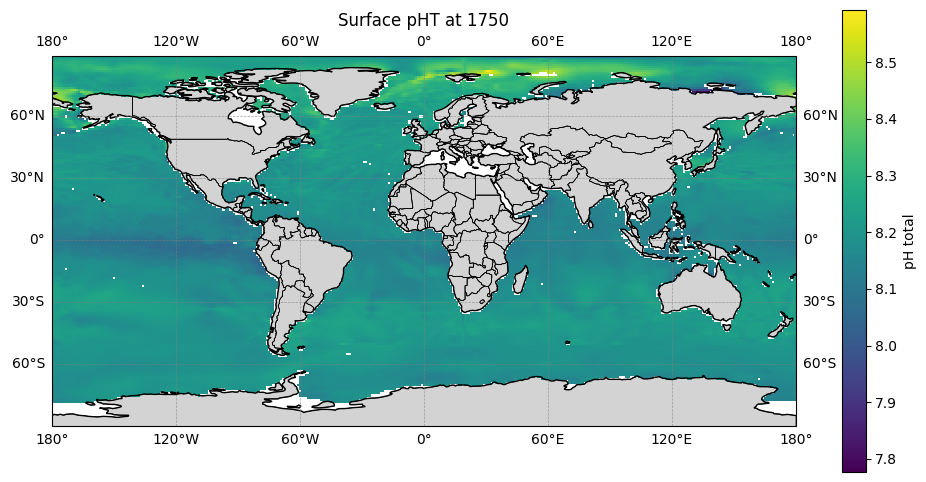

In [ ]:
# Select variable and first time step
da_plot = historical_and_ssp585['pHT'].isel(time=0)

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6),
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
pcm = da_plot.plot.pcolormesh(ax=ax,
                              transform=ccrs.PlateCarree(),
                              cmap='viridis',
                              add_colorbar=True,
                              cbar_kwargs={'label': 'pH total'})

# Add coastlines and borders
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Add country outlines
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                            name='admin_0_countries',
                                            scale='110m',
                                            facecolor='none'),
               edgecolor='black', linewidth=0.4)

# Add latitude and longitude gridlines with labels
gl = ax.gridlines(draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = True
gl.right_labels = True
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title and axis labels
ax.set_title('Surface pHT at 1750')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

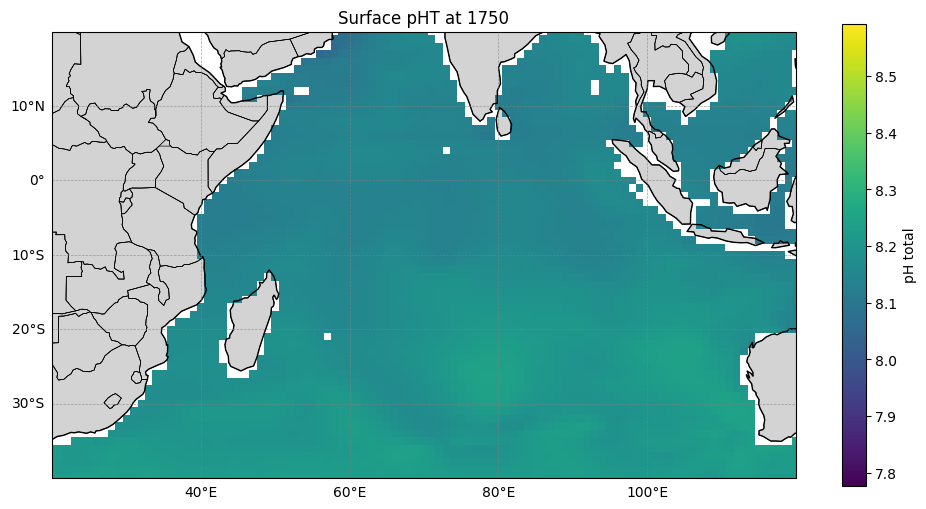

In [ ]:
# Select variable and first time step
da_plot = historical_and_ssp585['pHT'].isel(time=0)

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6),
                       subplot_kw={'projection': ccrs.PlateCarree()})
# Plot the data
pcm = da_plot.plot.pcolormesh(ax=ax,
                              transform=ccrs.PlateCarree(),
                              cmap='viridis',
                              add_colorbar=True,
                              cbar_kwargs={'label': 'pH total'})

# Add coastlines and borders
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Add country outlines
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                            name='admin_0_countries',
                                            scale='110m',
                                            facecolor='none'),
               edgecolor='black', linewidth=0.4)

# Add latitude and longitude gridlines with labels
gl = ax.gridlines(draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title and axis labels
ax.set_title('Surface pHT at 1750')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Chosing the area of interest
ax.set_extent([20, 120, -40, 20], crs=ccrs.PlateCarree())

plt.show()

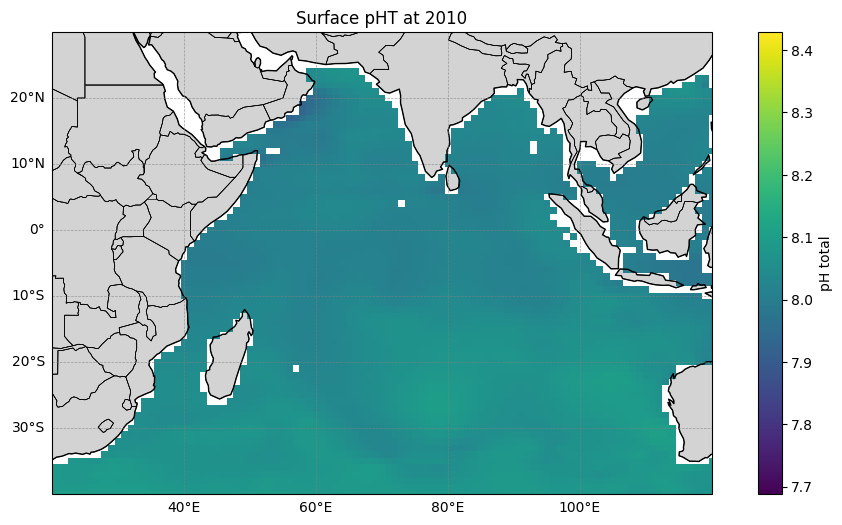

In [ ]:
# Select variable and first time step
da_plot = historical_and_ssp585['pHT'].isel(time=18)
#time slice 18 is 2010 (pseudopresent time)

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6),
                       subplot_kw={'projection': ccrs.PlateCarree()})
# Plot the data
pcm = da_plot.plot.pcolormesh(ax=ax,
                              transform=ccrs.PlateCarree(),
                              cmap='viridis',
                              add_colorbar=True,
                              cbar_kwargs={'label': 'pH total'})

# Add coastlines and borders
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Add country outlines
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                            name='admin_0_countries',
                                            scale='110m',
                                            facecolor='none'),
               edgecolor='black', linewidth=0.4)

# Add latitude and longitude gridlines with labels
gl = ax.gridlines(draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title and axis labels
ax.set_title('Surface pHT at 2010')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Chosing the area of interest
ax.set_extent([20, 120, -40, 30], crs=ccrs.PlateCarree())

plt.show()

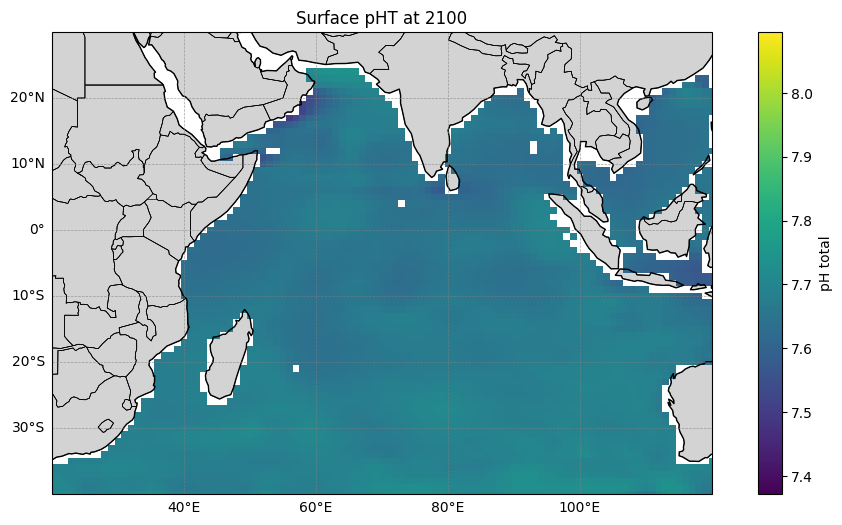

In [ ]:
# Select variable and first time step
da_plot = historical_and_ssp585['pHT'].isel(time=26)
#time slice 18 is 2010 (pseudopresent time)

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6),
                       subplot_kw={'projection': ccrs.PlateCarree()})
# Plot the data
pcm = da_plot.plot.pcolormesh(ax=ax,
                              transform=ccrs.PlateCarree(),
                              cmap='viridis',
                              add_colorbar=True,
                              cbar_kwargs={'label': 'pH total'})

# Add coastlines and borders
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Add country outlines
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                            name='admin_0_countries',
                                            scale='110m',
                                            facecolor='none'),
               edgecolor='black', linewidth=0.4)

# Add latitude and longitude gridlines with labels
gl = ax.gridlines(draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title and axis labels
ax.set_title('Surface pHT at 2100')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Chosing the area of interest
ax.set_extent([20, 120, -40, 30], crs=ccrs.PlateCarree())

plt.show()

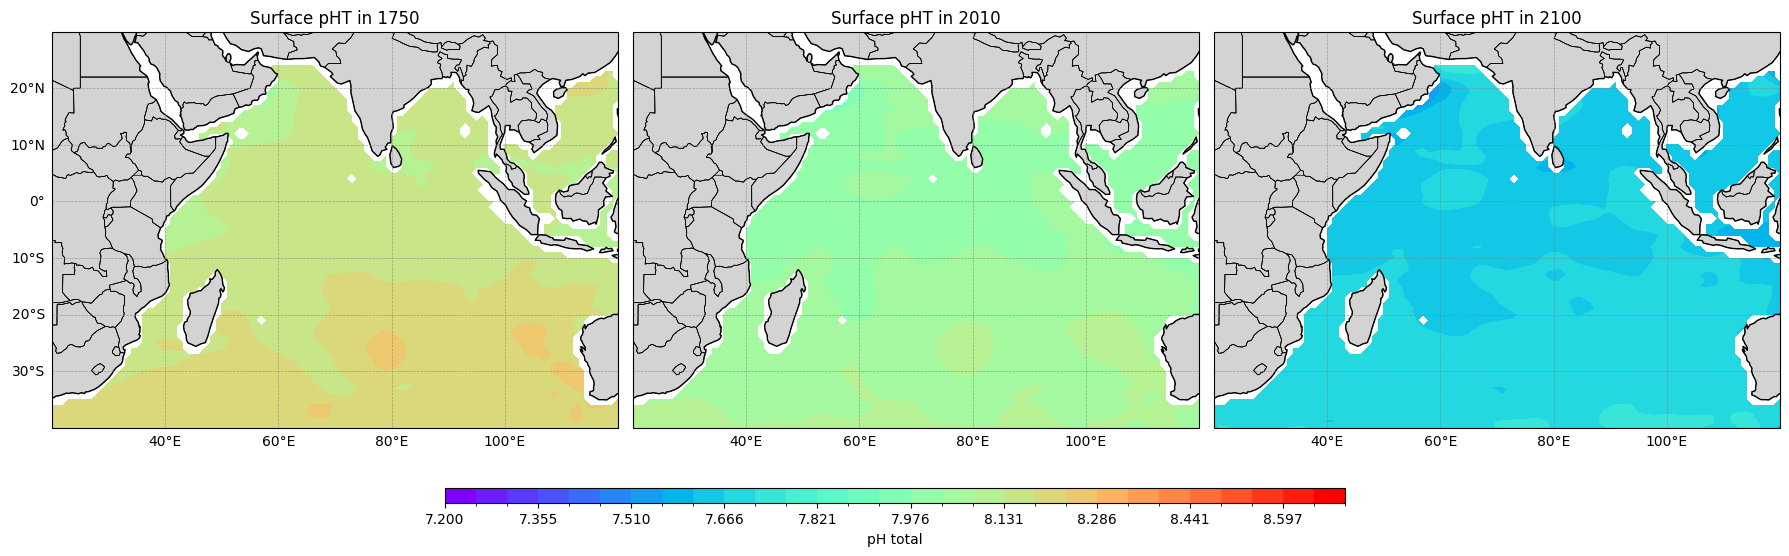

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define time indices and labels
time_indices = [0, 18, 26]
time_labels = ['1750', '2010', '2100']

# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6),
                         subplot_kw={'projection': ccrs.PlateCarree()})

# Store pcolormesh for colorbar
pcms = []

for i, (t_idx, label) in enumerate(zip(time_indices, time_labels)):
    ax = axes[i]
    da_plot = historical_and_ssp585['pHT'].isel(time=t_idx)

    # Plot the data and collect the pcolormesh for colorbar
    pcm = da_plot.plot.contourf(ax=ax,
                                levels=30,
                                  vmin=7.2,
                                  vmax=8.7,
                                    transform=ccrs.PlateCarree(),
                                  cmap='rainbow',
                                  add_colorbar=False)

    pcms.append(pcm)

    # Map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_0_countries',
                                                scale='110m',
                                                facecolor='none'),
                   edgecolor='black', linewidth=0.4)

    # Gridlines
    gl = ax.gridlines(draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    if i > 0:
        gl.left_labels = False

    # Set title and extent
    ax.set_title(f'Surface pHT in {label}')
    ax.set_extent([20, 120, -40, 30], crs=ccrs.PlateCarree())

# Adjust layout first to avoid overlap
plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space at bottom for colorbar

# Add horizontal colorbar below all maps
cbar_ax = fig.add_axes([0.25, 0.07, 0.5, 0.025])  # [left, bottom, width, height]
cbar = fig.colorbar(pcms[0], cax=cbar_ax, orientation='horizontal')
cbar.set_label('pH total')

plt.show()


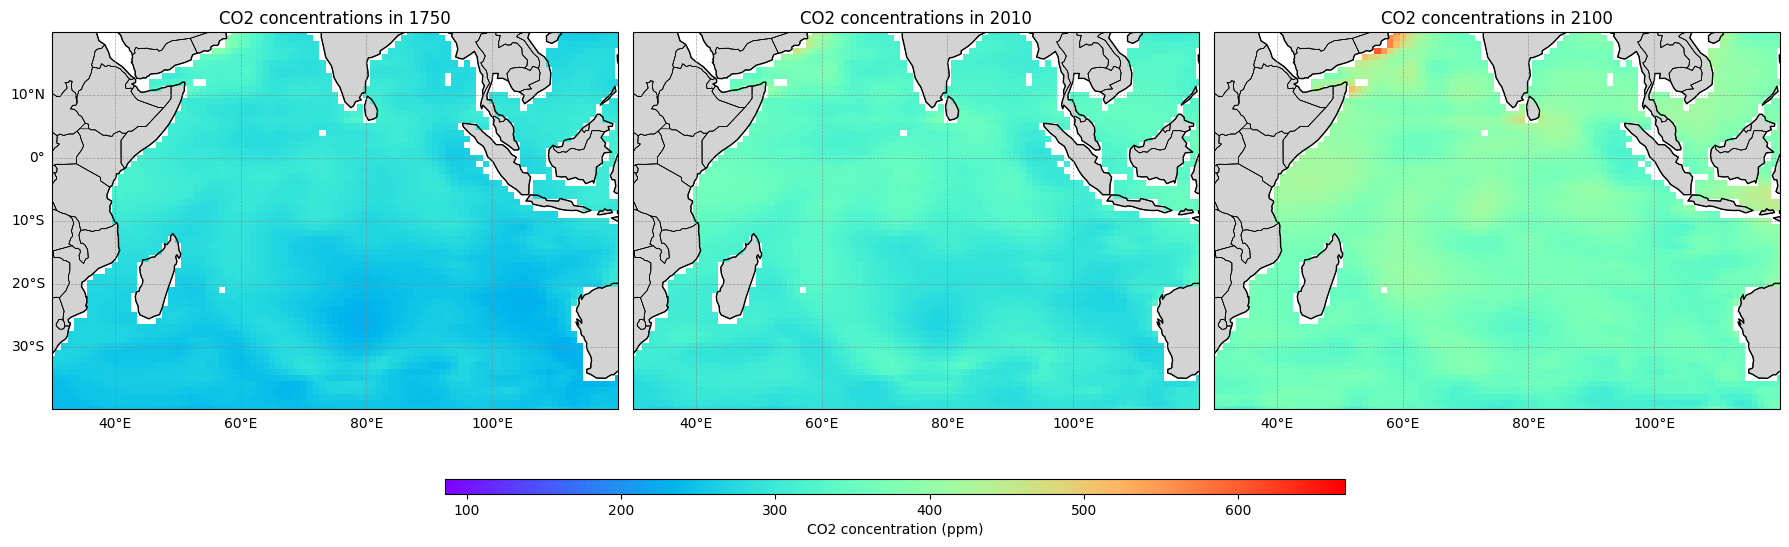

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define time indices and labels
time_indices = [0, 18, 26]
time_labels = ['1750', '2010', '2100']

# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6),
                         subplot_kw={'projection': ccrs.PlateCarree()})

# Store pcolormesh for colorbar
pcms = []

for i, (t_idx, label) in enumerate(zip(time_indices, time_labels)):
    ax = axes[i]
    da_plot = historical_and_ssp585['fCO2'].isel(time=t_idx)

    # Plot the data and collect the pcolormesh for colorbar
    pcm = da_plot.plot.pcolormesh(ax=ax,
                                  transform=ccrs.PlateCarree(),
                                  cmap='rainbow',
                                  add_colorbar=False)

    pcms.append(pcm)

    # Map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_0_countries',
                                                scale='110m',
                                                facecolor='none'),
                   edgecolor='black', linewidth=0.4)

    # Gridlines
    gl = ax.gridlines(draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    if i > 0:
        gl.left_labels = False

    # Set title and extent
    ax.set_title(f'CO2 concentrations in {label}')
    ax.set_extent([30, 120, -40, 20], crs=ccrs.PlateCarree())

# Adjust layout first to avoid overlap
plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space at bottom for colorbar

# Add horizontal colorbar below all maps
cbar_ax = fig.add_axes([0.25, 0.07, 0.5, 0.025])  # [left, bottom, width, height]
cbar = fig.colorbar(pcms[0], cax=cbar_ax, orientation='horizontal')
cbar.set_label('CO2 concentration (ppm)')


plt.show()


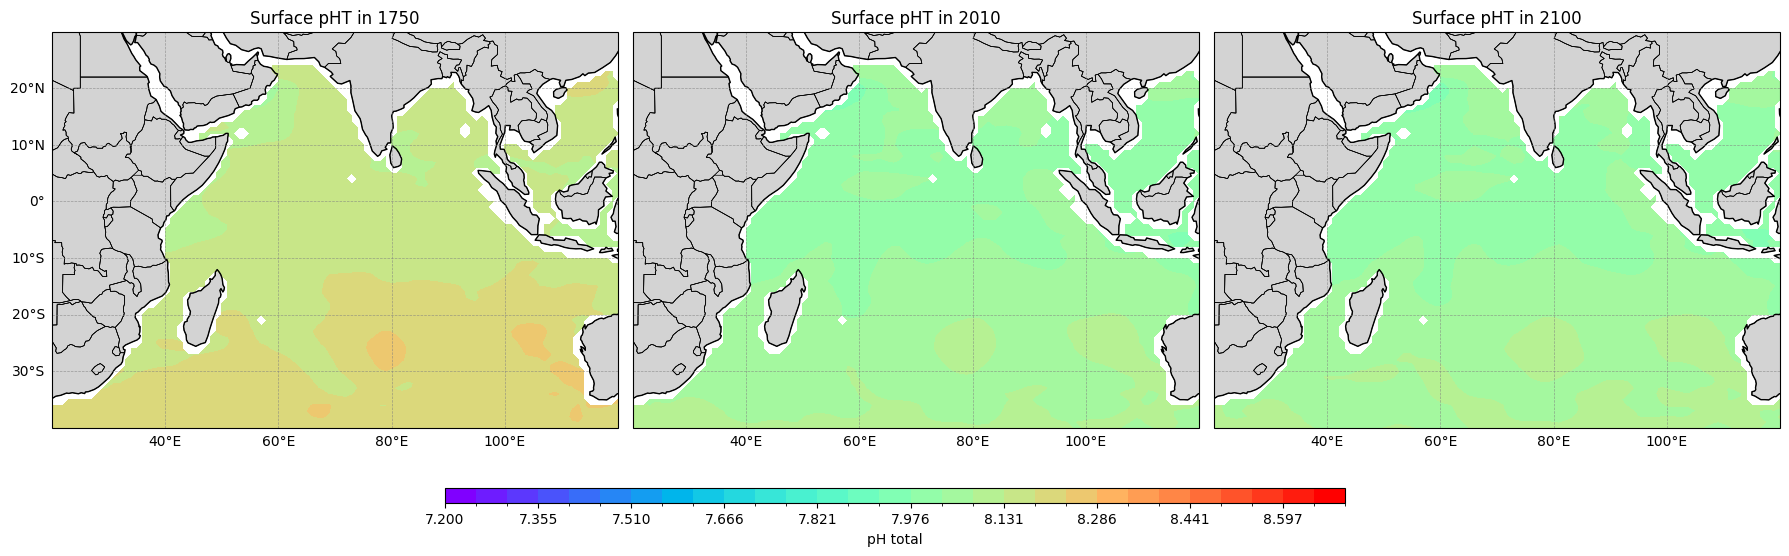

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define time indices and labels
time_indices = [0, 18, 26]
time_labels = ['1750', '2010', '2100']

# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6),
                         subplot_kw={'projection': ccrs.PlateCarree()})

# Store pcolormesh for colorbar
pcms = []

for i, (t_idx, label) in enumerate(zip(time_indices, time_labels)):
    ax = axes[i]
    da_plot = historical_and_ssp119['pHT'].isel(time=t_idx)

    # Plot the data and collect the pcolormesh for colorbar
    pcm = da_plot.plot.contourf(ax=ax,
                                levels=30,
                                  vmin=7.2,
                                  vmax=8.7,
                                    transform=ccrs.PlateCarree(),
                                  cmap='rainbow',
                                  add_colorbar=False)

    pcms.append(pcm)

    # Map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_0_countries',
                                                scale='110m',
                                                facecolor='none'),
                   edgecolor='black', linewidth=0.4)

    # Gridlines
    gl = ax.gridlines(draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    if i > 0:
        gl.left_labels = False

    # Set title and extent
    ax.set_title(f'Surface pHT in {label}')
    ax.set_extent([20, 120, -40, 30], crs=ccrs.PlateCarree())

# Adjust layout first to avoid overlap
plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space at bottom for colorbar

# Add horizontal colorbar below all maps
cbar_ax = fig.add_axes([0.25, 0.07, 0.5, 0.025])  # [left, bottom, width, height]
cbar = fig.colorbar(pcms[0], cax=cbar_ax, orientation='horizontal')
cbar.set_label('pH total')

plt.show()


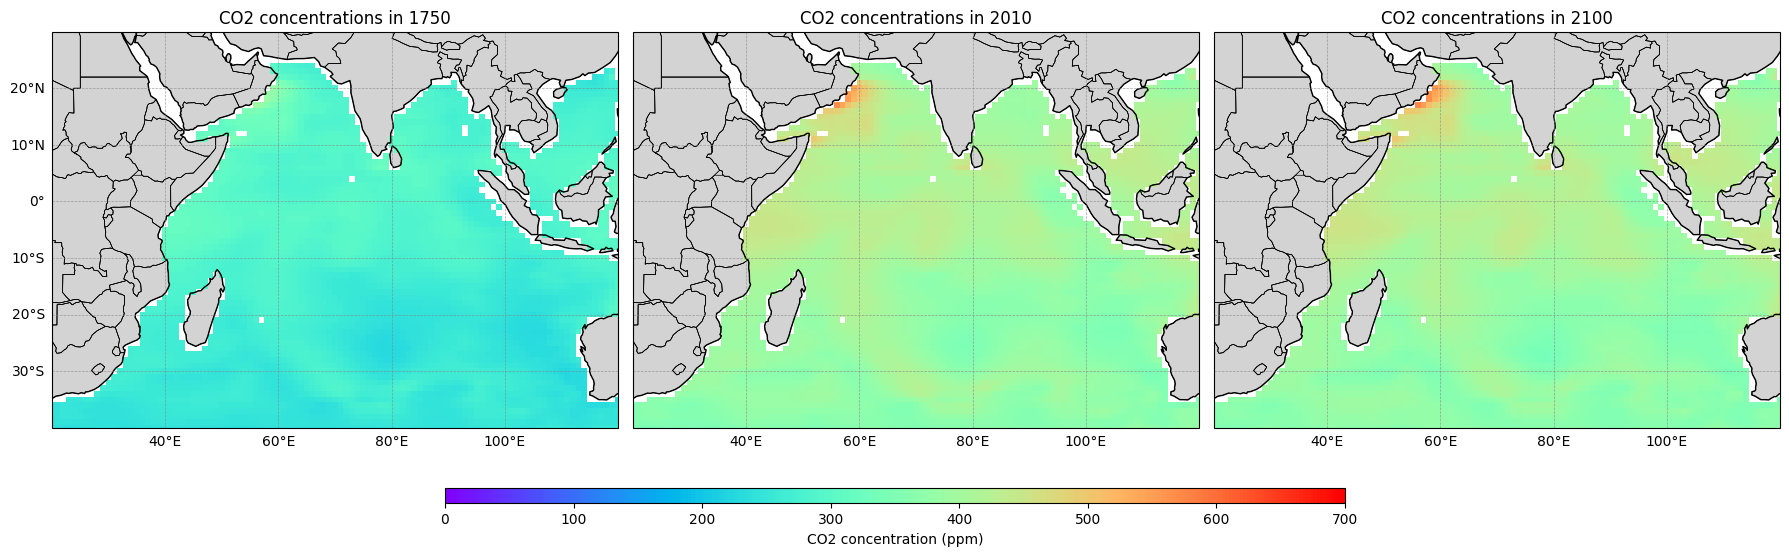

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define time indices and labels
time_indices = [0, 18, 26]
time_labels = ['1750', '2010', '2100']

# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6),
                         subplot_kw={'projection': ccrs.PlateCarree()})

# Store pcolormesh for colorbar
pcms = []

for i, (t_idx, label) in enumerate(zip(time_indices, time_labels)):
    ax = axes[i]
    da_plot = historical_and_ssp119['fCO2'].isel(time=t_idx)

    # Plot the data and collect the pcolormesh for colorbar
    pcm = da_plot.plot.pcolormesh(ax=ax,
                                  transform=ccrs.PlateCarree(),
                                  cmap='rainbow',
                                  vmin=0,
                                  vmax=700,
                                  add_colorbar=False)

    pcms.append(pcm)

    # Map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_0_countries',
                                                scale='110m',
                                                facecolor='none'),
                   edgecolor='black', linewidth=0.4)

    # Gridlines
    gl = ax.gridlines(draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    if i > 0:
        gl.left_labels = False

    # Set title and extent
    ax.set_title(f'CO2 concentrations in {label}')
    ax.set_extent([20, 120, -40, 30], crs=ccrs.PlateCarree())

# Adjust layout first to avoid overlap
plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space at bottom for colorbar

# Add horizontal colorbar below all maps
cbar_ax = fig.add_axes([0.25, 0.07, 0.5, 0.025])  # [left, bottom, width, height]
cbar = fig.colorbar(pcms[0], cax=cbar_ax, orientation='horizontal')
cbar.set_label('CO2 concentration (ppm)')

plt.show()


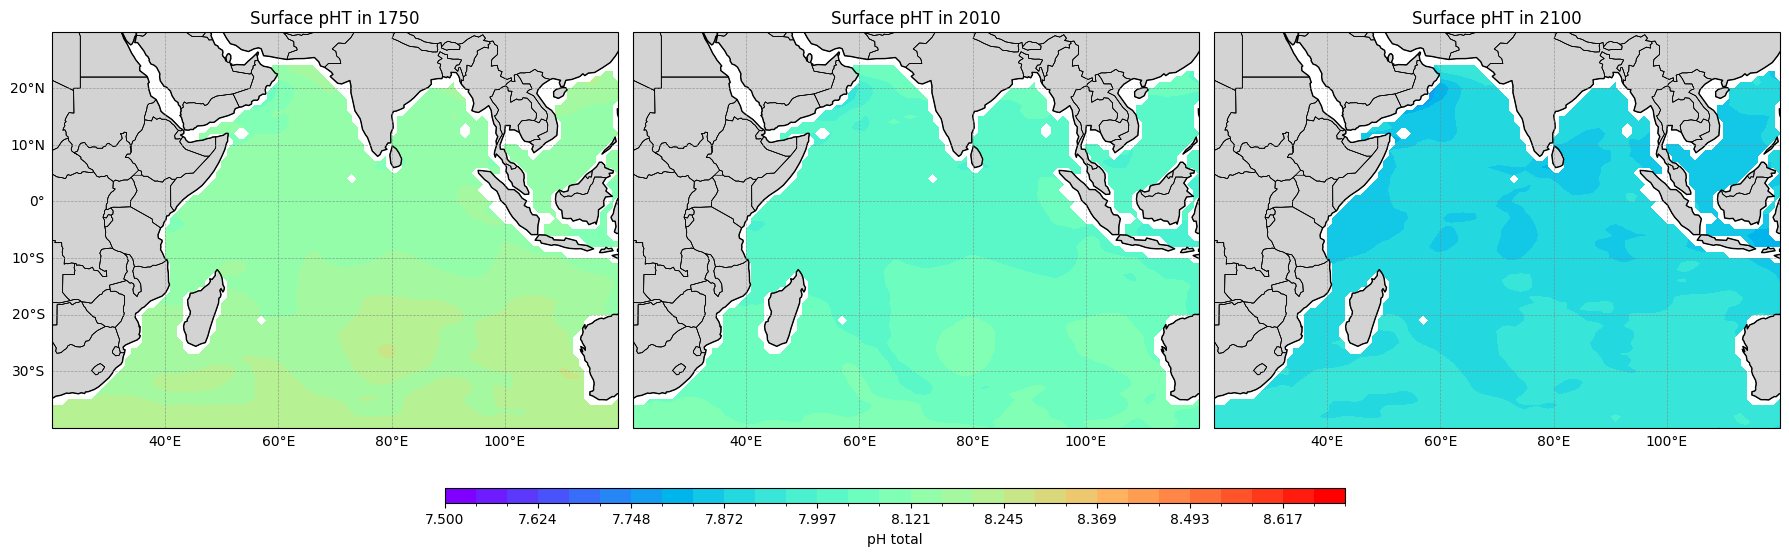

In [ ]:
# Define time indices and labels
time_indices = [0, 18, 26]
time_labels = ['1750', '2010', '2100']

# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6),
                         subplot_kw={'projection': ccrs.PlateCarree()})

# Store pcolormesh for colorbar
pcms = []

for i, (t_idx, label) in enumerate(zip(time_indices, time_labels)):
    ax = axes[i]
    da_plot = historical_and_ssp245['pHT'].isel(time=t_idx)

    # Plot the data and collect the pcolormesh for colorbar
    pcm = da_plot.plot.contourf(ax=ax,
                                levels=30,
                                  vmin=7.5,
                                  vmax=8.7,
                                    transform=ccrs.PlateCarree(),
                                  cmap='rainbow',
                                  add_colorbar=False)

    pcms.append(pcm)

    # Map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_0_countries',
                                                scale='110m',
                                                facecolor='none'),
                   edgecolor='black', linewidth=0.4)

    # Gridlines
    gl = ax.gridlines(draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    if i > 0:
        gl.left_labels = False

    # Set title and extent
    ax.set_title(f'Surface pHT in {label}')
    ax.set_extent([20, 120, -40, 30], crs=ccrs.PlateCarree())

# Adjust layout first to avoid overlap
plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space at bottom for colorbar

# Add horizontal colorbar below all maps
cbar_ax = fig.add_axes([0.25, 0.07, 0.5, 0.025])  # [left, bottom, width, height]
cbar = fig.colorbar(pcms[0], cax=cbar_ax, orientation='horizontal')
cbar.set_label('pH total')

plt.show()

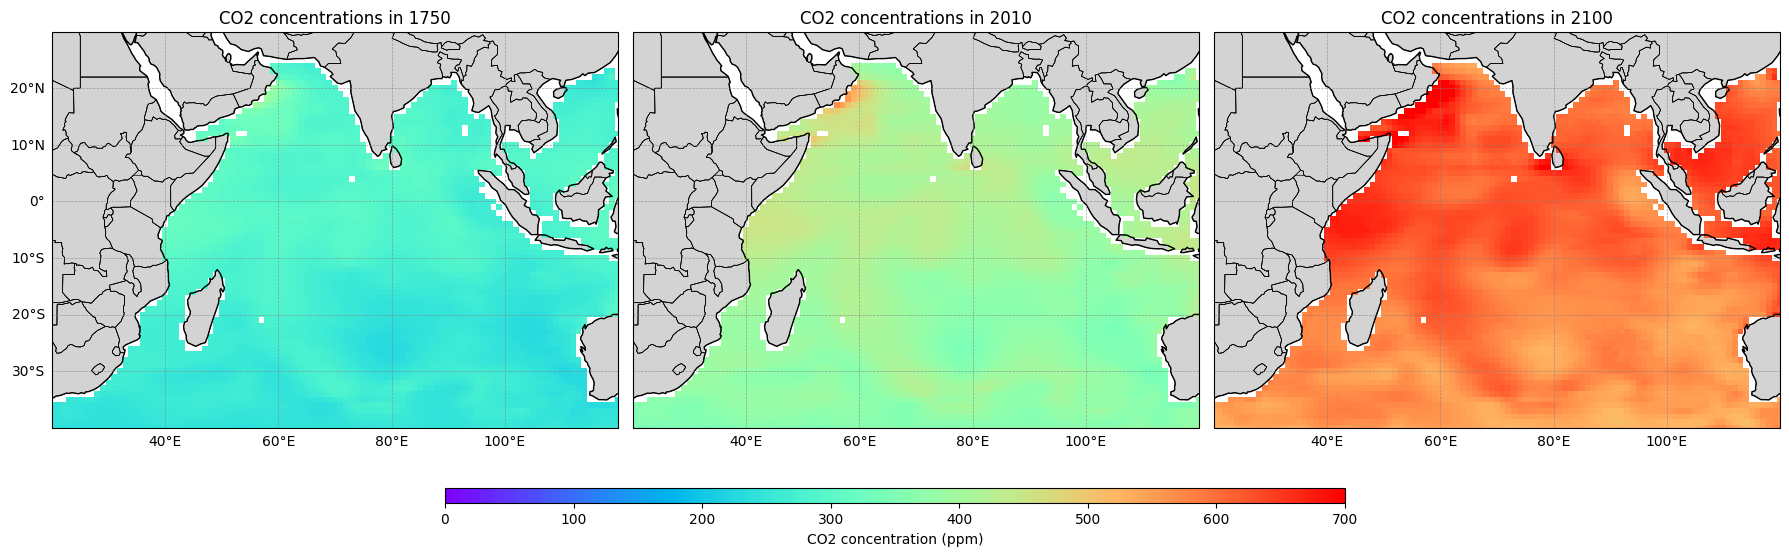

In [ ]:

# Define time indices and labels
time_indices = [0, 18, 26]
time_labels = ['1750', '2010', '2100']

# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6),
                         subplot_kw={'projection': ccrs.PlateCarree()})

# Store pcolormesh for colorbar
pcms = []


for i, (t_idx, label) in enumerate(zip(time_indices, time_labels)):
    ax = axes[i]
    da_plot = historical_and_ssp245['fCO2'].isel(time=t_idx)

    # Plot the data and collect the pcolormesh for colorbar
    pcm = da_plot.plot.pcolormesh(ax=ax,
                                  transform=ccrs.PlateCarree(),
                                  cmap='rainbow',
                                  vmin=0,
                                  vmax=700,
                                  add_colorbar=False)

    pcms.append(pcm)

    # Map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_0_countries',
                                                scale='110m',
                                                facecolor='none'),
                   edgecolor='black', linewidth=0.4)

    # Gridlines
    gl = ax.gridlines(draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    if i > 0:
        gl.left_labels = False

    # Set title and extent
    ax.set_title(f'CO2 concentrations in {label}')
    ax.set_extent([20, 120, -40, 30], crs=ccrs.PlateCarree())

# Adjust layout first to avoid overlap
plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space at bottom for colorbar

# Add horizontal colorbar below all maps
cbar_ax = fig.add_axes([0.25, 0.07, 0.5, 0.025])  # [left, bottom, width, height]
cbar = fig.colorbar(pcms[0], cax=cbar_ax, orientation='horizontal')
cbar.set_label('CO2 concentration (ppm)')

plt.show()

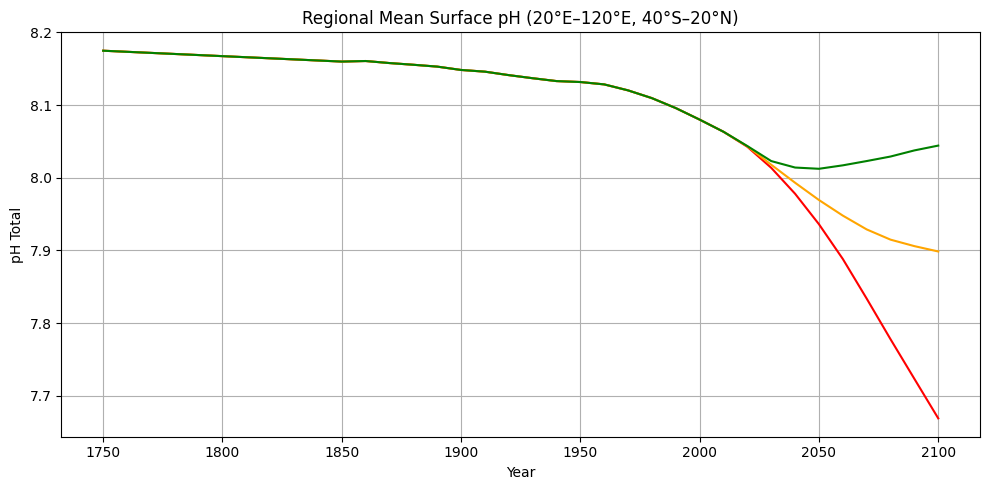

In [ ]:
# Select region: e.g., [20E–120E, 40S–20N]
regional_pH1 = historical_and_ssp585['pHT'].sel(lon=slice(20, 120), lat=slice(-40, 20)).mean(dim=['lat', 'lon'])

regional_pH2 = historical_and_ssp245['pHT'].sel(lon=slice(20, 120), lat=slice(-40, 20)).mean(dim=['lat', 'lon'])

regional_pH3 = historical_and_ssp119['pHT'].sel(lon=slice(20, 120), lat=slice(-40, 20)).mean(dim=['lat', 'lon'])

plt.figure(figsize=(10, 5))
plt.plot(historical_and_ssp585['time'], regional_pH1, color='red')
plt.plot(historical_and_ssp245['time'], regional_pH2, color='orange')
plt.plot(historical_and_ssp119['time'], regional_pH3, color='green')
plt.title('Regional Mean Surface pH (20°E–120°E, 40°S–20°N)')
plt.xlabel('Year')
plt.ylabel('pH Total')
plt.grid(True)
plt.tight_layout()
plt.show()


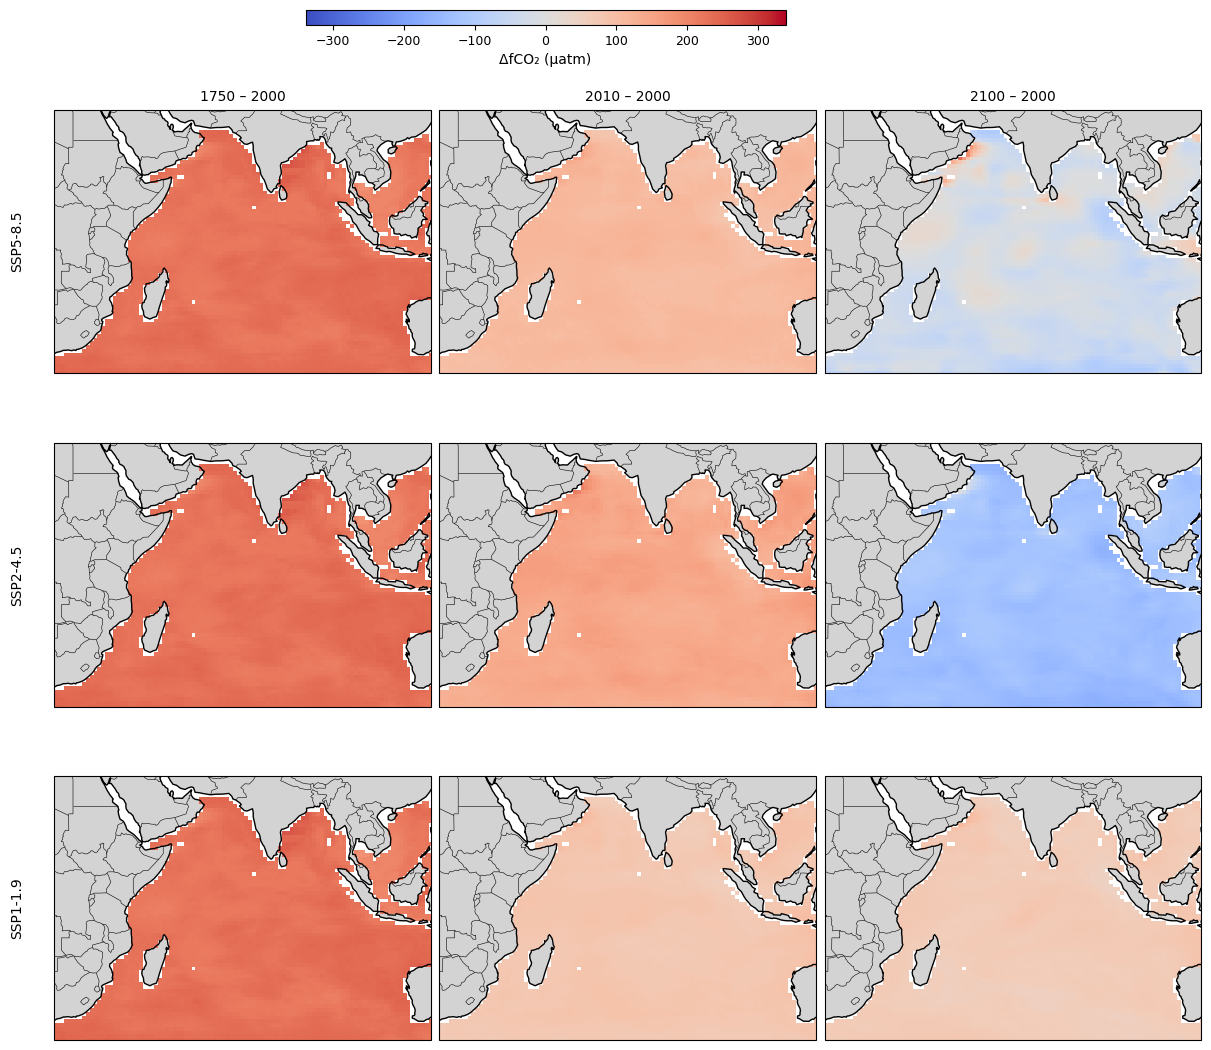

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ------------------------------------------------------------------
# 1.  Which scenarios and datasets?
# ------------------------------------------------------------------
datasets = {
    "SSP5‑8.5": historical_and_ssp585,
    "SSP2‑4.5": historical_and_ssp245,
    "SSP1‑1.9": historical_and_ssp119,
}

# ------------------------------------------------------------------
# 2.  Which time slices do you want to show?
#     (These are 0‑based indices into the 'time' dimension)
# ------------------------------------------------------------------
time_indices = [0, 18, 26]
time_labels  = ["1750", "2010", "2100"]  # same length as above

# ------------------------------------------------------------------
# 3.  Plot grid dimensions
# ------------------------------------------------------------------
n_rows = len(datasets)                  # one row per scenario
n_cols = len(time_indices)              # one column per year

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12, 10),
    subplot_kw={"projection": ccrs.PlateCarree()},
    constrained_layout=True,            # replaces tight_layout
)

# ------------------------------------------------------------------
# 4.  Loop through scenarios (rows) and years (columns)
# ------------------------------------------------------------------
for row, (scenario, ds) in enumerate(datasets.items()):
    # Baseline: index 14 → year 2000 in your files
    baseline = ds["fCO2"].isel(time=14)   # 2‑D DataArray (lat, lon)

    for col, (t_idx, t_label) in enumerate(zip(time_indices, time_labels)):
        ax  = axes[row, col]
        diff = ds["fCO2"].isel(time=t_idx) - baseline

        pcm = diff.plot.pcolormesh(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap="coolwarm",
            add_colorbar=False,
        )

        # Map decorations
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.4)
        ax.add_feature(cfeature.LAND, facecolor="lightgray")
        ax.set_extent([20, 120, -40, 30], crs=ccrs.PlateCarree())

        # Titles & row labels
        if row == 0:
            ax.set_title(f"{t_label} – 2000", fontsize=10)
        if col == 0:
            ax.text(
                -0.08, 0.5, scenario,
                transform=ax.transAxes,
                rotation=90, va="center", ha="right",
                fontsize=10,
            )

# ------------------------------------------------------------------
# 5.  Shared colorbar
# ------------------------------------------------------------------

cbar_ax = fig.add_axes([0.25, 1.05, 0.4, 0.015])
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation="horizontal")
cbar.set_label("ΔfCO₂ (µatm)")
cbar.ax.tick_params(labelsize=9)

plt.show()


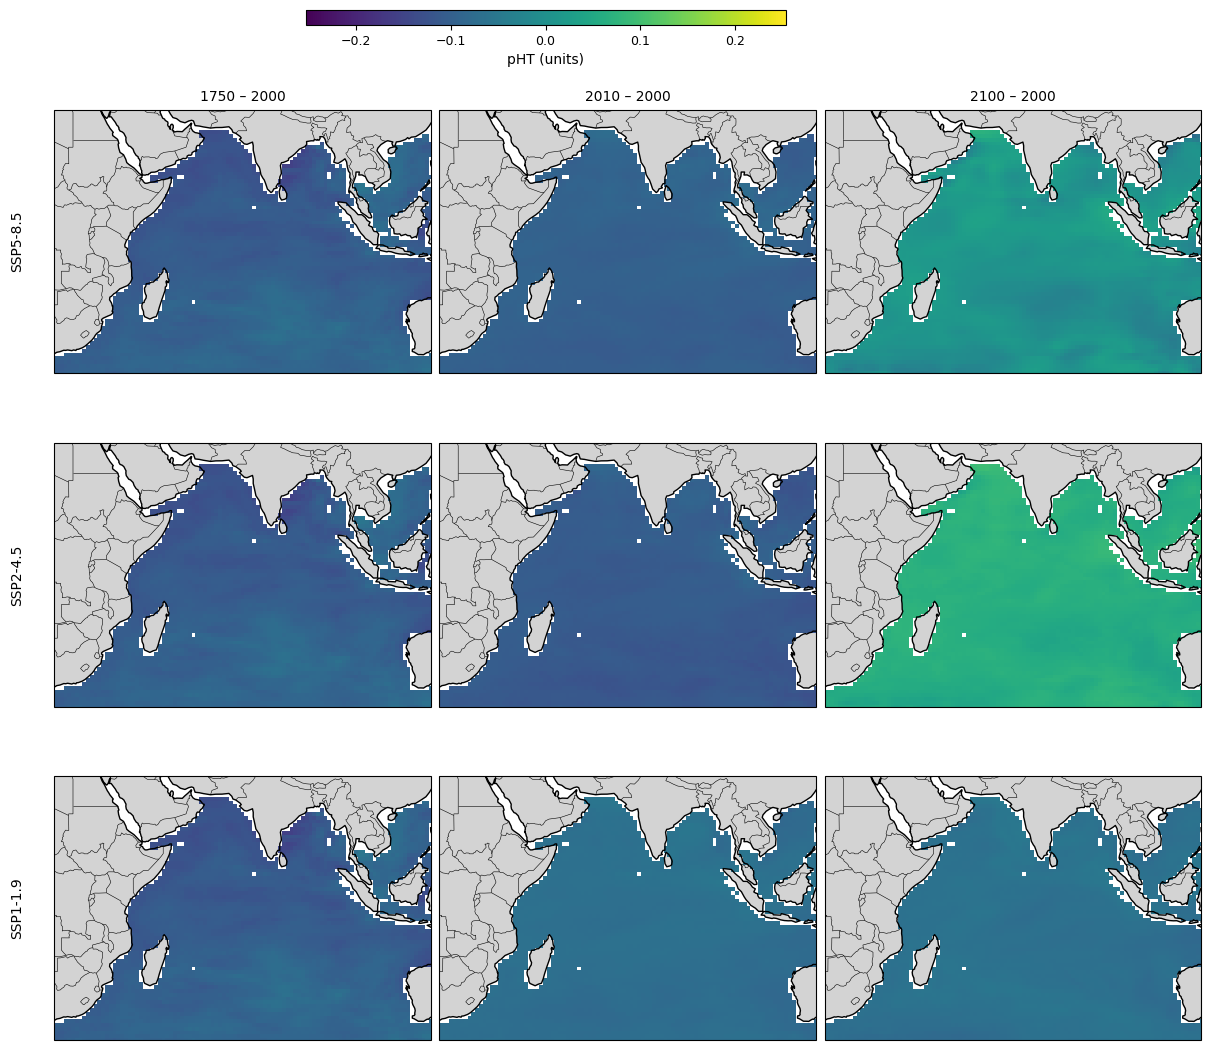

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ------------------------------------------------------------------
# 1.  Which scenarios and datasets?
# ------------------------------------------------------------------
datasets = {
    "SSP5‑8.5": historical_and_ssp585,
    "SSP2‑4.5": historical_and_ssp245,
    "SSP1‑1.9": historical_and_ssp119,
}

# ------------------------------------------------------------------
# 2.  Which time slices do you want to show?
#     (These are 0‑based indices into the 'time' dimension)
# ------------------------------------------------------------------
time_indices = [0, 18, 26]
time_labels  = ["1750", "2010", "2100"]  # same length as above

# ------------------------------------------------------------------
# 3.  Plot grid dimensions
# ------------------------------------------------------------------
n_rows = len(datasets)                  # one row per scenario
n_cols = len(time_indices)              # one column per year

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12, 10),
    subplot_kw={"projection": ccrs.PlateCarree()},
    constrained_layout=True,            # replaces tight_layout
)

# ------------------------------------------------------------------
# 4.  Loop through scenarios (rows) and years (columns)
# ------------------------------------------------------------------
for row, (scenario, ds) in enumerate(datasets.items()):
    # Baseline: index 14 → year 2000 in your files
    baseline = ds["pHT"].isel(time=14)   # 2‑D DataArray (lat, lon)

    for col, (t_idx, t_label) in enumerate(zip(time_indices, time_labels)):
        ax  = axes[row, col]
        diff = ds["pHT"].isel(time=t_idx) - baseline

        pcm = diff.plot.pcolormesh(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap="viridis",
            add_colorbar=False,
        )

        # Map decorations
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.4)
        ax.add_feature(cfeature.LAND, facecolor="lightgray")
        ax.set_extent([20, 120, -40, 30], crs=ccrs.PlateCarree())

        # Titles & row labels
        if row == 0:
            ax.set_title(f"{t_label} – 2000", fontsize=10)
        if col == 0:
            ax.text(
                -0.08, 0.5, scenario,
                transform=ax.transAxes,
                rotation=90, va="center", ha="right",
                fontsize=10,
            )

# ------------------------------------------------------------------
# 5.  Shared colorbar
# ------------------------------------------------------------------

cbar_ax = fig.add_axes([0.25, 1.05, 0.4, 0.015])
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation="horizontal")
cbar.set_label("pHT (units)")
cbar.ax.tick_params(labelsize=9)

plt.show()


6.171107994389902 58.789625360230545
0.0 0.0
-397.46835443037975 -32.47863247863248
6.171107994389902 58.789625360230545
0.0 0.0
-186.21553884711778 27.643312101910826
6.171107994389902 58.789625360230545
0.0 0.0
-59.9236641221374 40.577716643741404


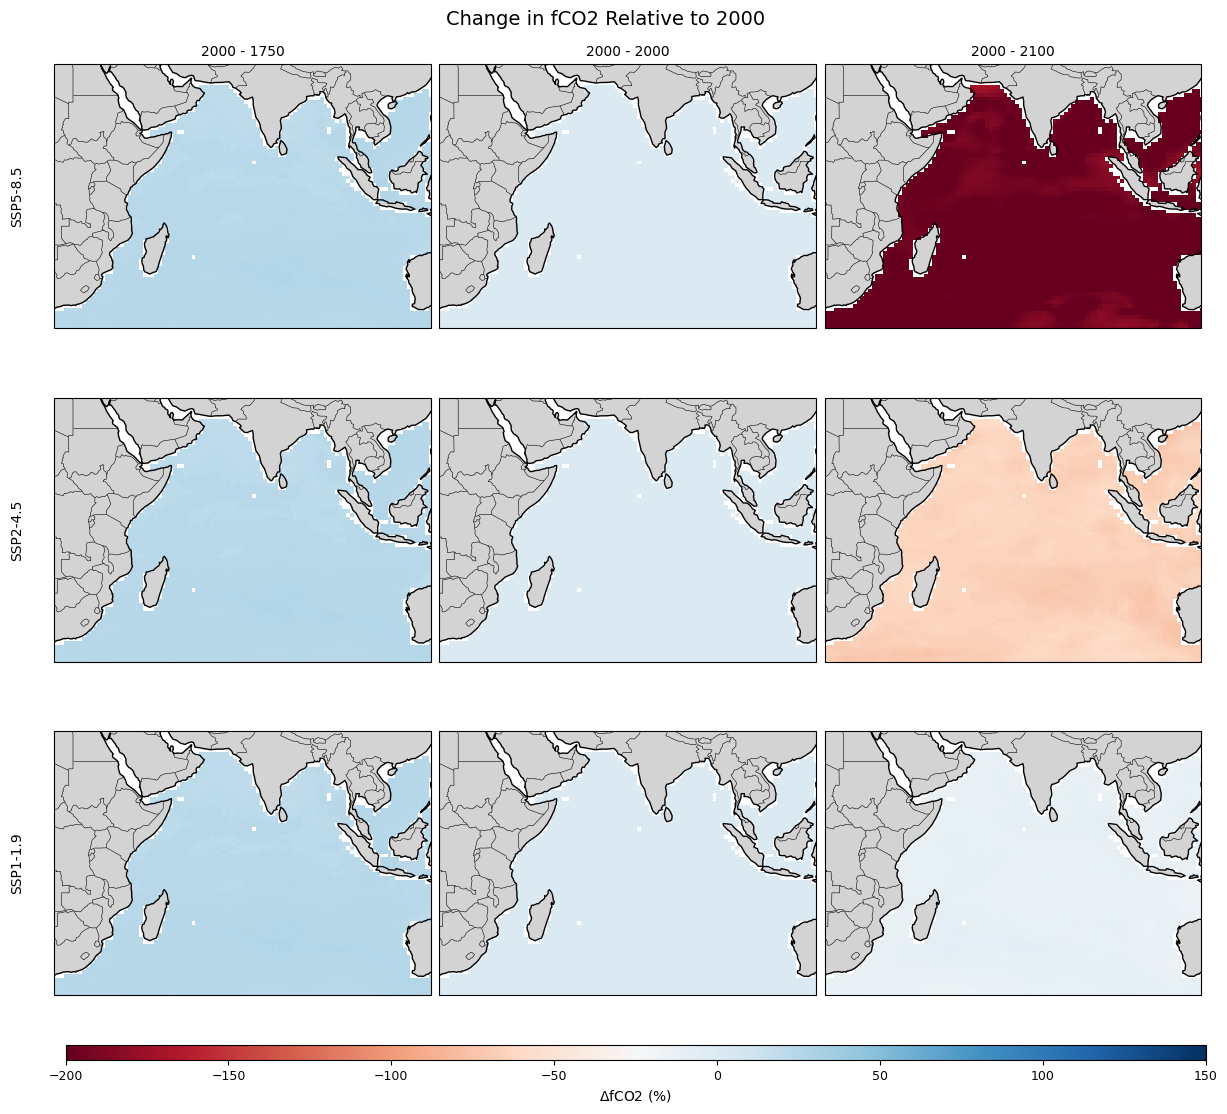

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ------------------------------------------------------------------
# 1.  Which scenarios and datasets?
# ------------------------------------------------------------------
datasets = {
    "SSP5‑8.5": historical_and_ssp585,
    "SSP2‑4.5": historical_and_ssp245,
    "SSP1‑1.9": historical_and_ssp119,
}

# ------------------------------------------------------------------
# 2.  Which time slices do you want to show?
#     (These are 0‑based indices into the 'time' dimension)
# ------------------------------------------------------------------
# time_indices = [0, 18, 26]
times = ["1750", "2000", "2100"]  # same length as above

# ------------------------------------------------------------------
# 3.  Plot grid dimensions
# ------------------------------------------------------------------
n_rows = len(datasets)                  # one row per scenario
n_cols = len(time_indices)              # one column per year

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12, 10),
    subplot_kw={"projection": ccrs.PlateCarree()},
    constrained_layout=True,            # replaces tight_layout
)

# ------------------------------------------------------------------
# 4.  Loop through scenarios (rows) and years (columns)
# ------------------------------------------------------------------
for row, (scenario, ds) in enumerate(datasets.items()):
    # Baseline: index 14 → year 2000 in your files
    baseline = ds["fCO2"].sel(time='2000')   # 2‑D DataArray (lat, lon)


    for col, time in enumerate(times):
        ax  = axes[row, col]
        diff = 100*(baseline - ds["fCO2"].sel(time=time)) / baseline
        # print(time)
        print(np.nanmin(diff.values), np.nanmax(diff.values))


        pcm = diff.plot.pcolormesh(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap="RdBu",
            vmin=-200,
            vmax=150,
            add_colorbar=False,
            add_labels=False,
        )

        # Map decorations
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.4)
        ax.add_feature(cfeature.LAND, facecolor="lightgray")
        ax.set_extent([20, 120, -40, 30], crs=ccrs.PlateCarree())

        # Titles & row labels
        if row == 0:
            ax.set_title(f"2000 - {time}", fontsize=10)
        if col == 0:
            ax.text(
                -0.08, 0.5, scenario,
                transform=ax.transAxes,
                rotation=90, va="center", ha="right",
                fontsize=10,
            )

# ------------------------------------------------------------------
# 5.  Shared colorbar
# ------------------------------------------------------------------

# Add colorbar at bottom right
cbar_ax = fig.add_axes([0.05, -0.03, 0.95, 0.015])  # [left/right, up/down, width, height]
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation="horizontal")
cbar.set_label("$\Delta$fCO2 (%)")
cbar.ax.tick_params(labelsize=9)

fig.suptitle("Change in fCO2 Relative to 2000", fontsize=14, y=1.02)

plt.show()

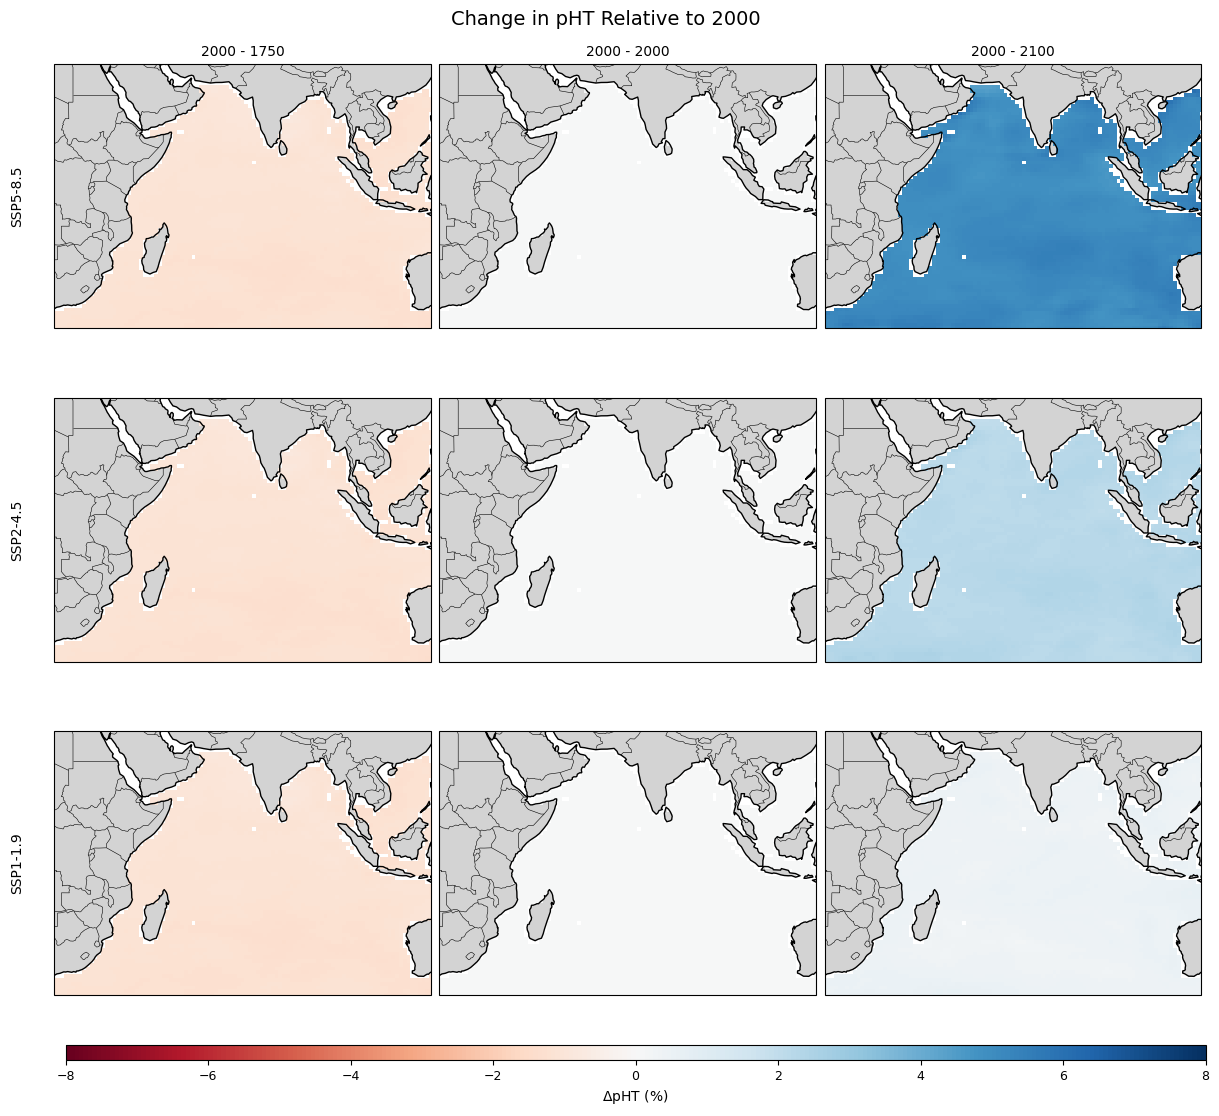

In [ ]:
# ------------------------------------------------------------------
# 1.  Which scenarios and datasets?
# ------------------------------------------------------------------
datasets = {
    "SSP5‑8.5": historical_and_ssp585,
    "SSP2‑4.5": historical_and_ssp245,
    "SSP1‑1.9": historical_and_ssp119,
}

# ------------------------------------------------------------------
# 2.  Which time slices do you want to show?
#     (These are 0‑based indices into the 'time' dimension)
# ------------------------------------------------------------------
# time_indices = [0, 18, 26]
times = ["1750", "2000", "2100"]  # same length as above

# ------------------------------------------------------------------
# 3.  Plot grid dimensions
# ------------------------------------------------------------------
n_rows = len(datasets)                  # one row per scenario
n_cols = len(time_indices)              # one column per year

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12, 10),
    subplot_kw={"projection": ccrs.PlateCarree()},
    constrained_layout=True,            # replaces tight_layout
)

# ------------------------------------------------------------------
# 4.  Loop through scenarios (rows) and years (columns)
# ------------------------------------------------------------------
for row, (scenario, ds) in enumerate(datasets.items()):
    # Baseline: index 14 → year 2000 in your files
    baseline = ds["pHT"].sel(time='2000')   # 2‑D DataArray (lat, lon)

    for col, time in enumerate(times):
        ax  = axes[row, col]
        diff = 100*(baseline - ds["pHT"].sel(time=time)) / baseline
        # print(time)


        pcm = diff.plot.pcolormesh(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap="RdBu",
            vmin=-8,
            vmax=8,
            add_colorbar=False,
            add_labels=False,
        )

        # Map decorations
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.4)
        ax.add_feature(cfeature.LAND, facecolor="lightgray")
        ax.set_extent([20, 120, -40, 30], crs=ccrs.PlateCarree())

        # Titles & row labels
        if row == 0:
            ax.set_title(f"2000 - {time}", fontsize=10)
        if col == 0:
            ax.text(
                -0.08, 0.5, scenario,
                transform=ax.transAxes,
                rotation=90, va="center", ha="right",
                fontsize=10,
            )

# ------------------------------------------------------------------
# 5.  Shared colorbar
# ------------------------------------------------------------------

# Add colorbar at bottom right
cbar_ax = fig.add_axes([0.05, -0.03, 0.95, 0.015])  # [left/right, up/down, width, height]
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation="horizontal")
cbar.set_label("$\Delta$pHT (%)")
cbar.ax.tick_params(labelsize=9)

fig.suptitle("Change in pHT Relative to 2000", fontsize=14, y=1.02)

plt.show()

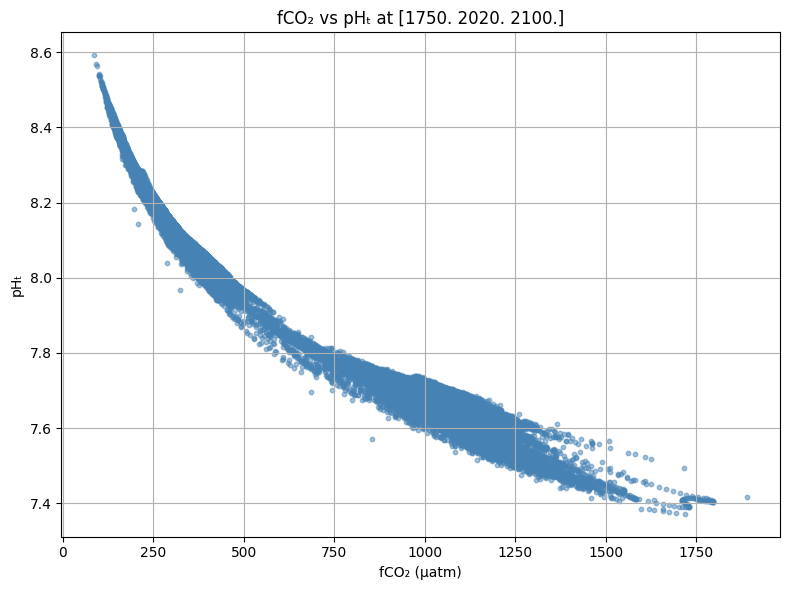

In [ ]:

# Example: choose a single time step (e.g., 2010 = index 18)
time_index = [0,18,26]
ds = historical_and_ssp585  # or any other scenario dataset

# Extract variables at the same time
fCO2 = ds["fCO2"].isel(time=time_index)
pHT = ds["pHT"].isel(time=time_index)

# Make sure the shapes match (lat, lon)
assert fCO2.shape == pHT.shape

# Flatten both arrays and remove NaNs
fCO2_flat = fCO2.values.flatten()
pHT_flat = pHT.values.flatten()
mask = ~np.isnan(fCO2_flat) & ~np.isnan(pHT_flat)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(fCO2_flat[mask], pHT_flat[mask], s=10, alpha=0.5, color='steelblue')
plt.xlabel("fCO₂ (µatm)")
plt.ylabel("pHₜ")
plt.title(f"fCO₂ vs pHₜ at {ds['time'].isel(time=time_index).values}")
plt.grid(True)
plt.tight_layout()
plt.show()

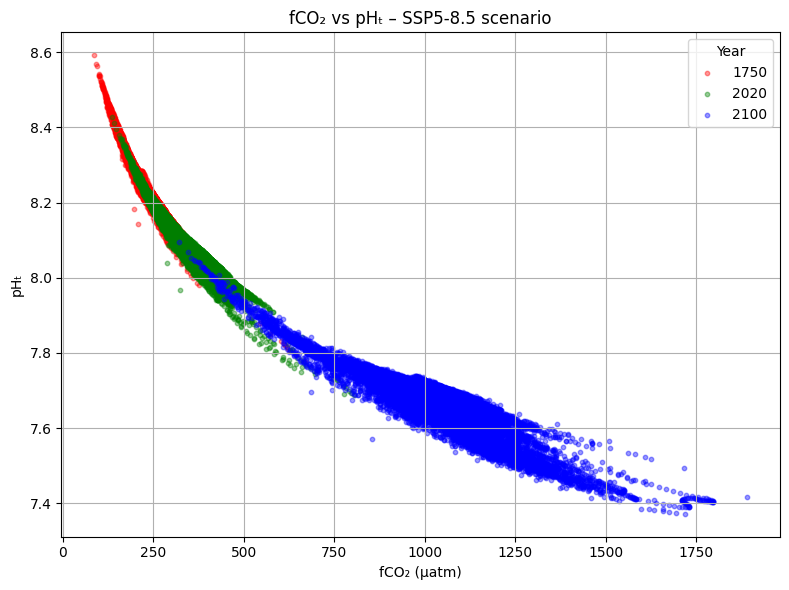

In [ ]:
# --------------------------------------------------
# 1.  Choose time slices (0‑based indices into ds.time)
# --------------------------------------------------
time_indices = [0, 18, 26]
colors       = ['red', 'green', 'blue']  # one colour per slice

# --------------------------------------------------
# 2.  Select the dataset (SSP5‑8.5 in this example)
# --------------------------------------------------
ds = historical_and_ssp585          # already in memory

# --------------------------------------------------
# 3.  Build the scatter plot
# --------------------------------------------------
plt.figure(figsize=(8, 6))

for idx, colour in zip(time_indices, colors):
    # Extract 2‑D fields at this time
    fCO2 = ds['fCO2'].isel(time=idx)
    pHT  = ds['pHT' ].isel(time=idx)

    # Flatten and mask NaNs
    fCO2_flat = fCO2.values.ravel()
    pHT_flat  = pHT .values.ravel()
    mask = ~np.isnan(fCO2_flat) & ~np.isnan(pHT_flat)

    # Get a readable year label
    # The time coordinate is already a float representing the year
    year_label = str(int(ds['time'].isel(time=idx).values))


    # Scatter
    plt.scatter(fCO2_flat[mask],
                pHT_flat [mask],
                s=10, alpha=0.4, color=colour,
                label=year_label)

# Plot cosmetics
plt.xlabel("fCO₂ (µatm)")
plt.ylabel("pHₜ")
plt.title("fCO₂ vs pHₜ – SSP5‑8.5 scenario")
plt.legend(title="Year")
plt.grid(True)
plt.tight_layout()
plt.show()

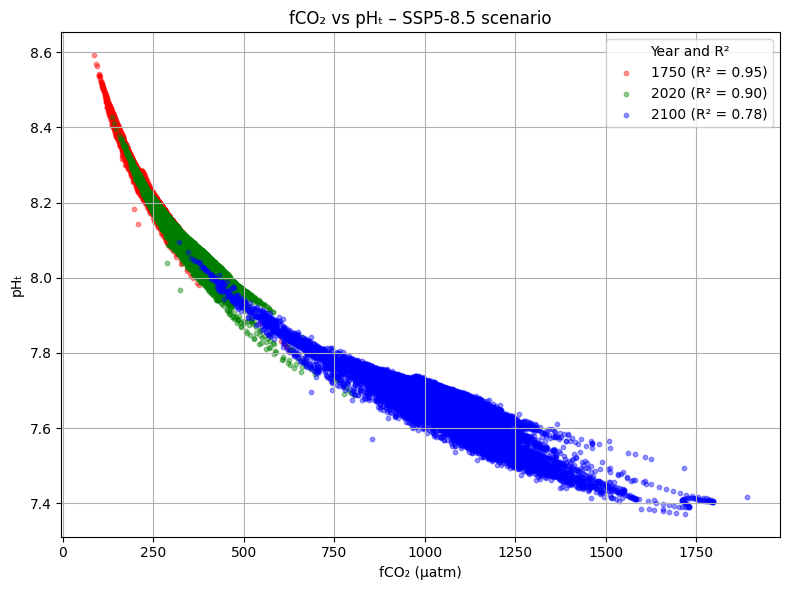

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# --------------------------------------------------
# 1.  Choose time slices (0‑based indices into ds.time)
# --------------------------------------------------
time_indices = [0, 18, 26]
colors       = ['red', 'green', 'blue']  # one colour per slice

# --------------------------------------------------
# 2.  Select the dataset (SSP5‑8.5 in this example)
# --------------------------------------------------
ds = historical_and_ssp585          # already in memory

# --------------------------------------------------
# 3.  Build the scatter plot
# --------------------------------------------------
plt.figure(figsize=(8, 6))

for idx, colour in zip(time_indices, colors):
    # Extract 2‑D fields at this time
    fCO2 = ds['fCO2'].isel(time=idx)
    pHT  = ds['pHT' ].isel(time=idx)

    # Flatten and mask NaNs
    fCO2_flat = fCO2.values.ravel()
    pHT_flat  = pHT .values.ravel()
    mask = ~np.isnan(fCO2_flat) & ~np.isnan(pHT_flat)

    # Compute R²
    slope, intercept, r_value, _, _ = linregress(fCO2_flat[mask], pHT_flat[mask])
    r_squared = r_value ** 2

    # Get a readable year label
    year_label = str(int(ds['time'].isel(time=idx).values))
    label_with_r2 = f"{year_label} (R² = {r_squared:.2f})"

    # Scatter
    plt.scatter(fCO2_flat[mask],
                pHT_flat [mask],
                s=10, alpha=0.4, color=colour,
                label=label_with_r2)

# Plot cosmetics
plt.xlabel("fCO₂ (µatm)")
plt.ylabel("pHₜ")
plt.title("fCO₂ vs pHₜ – SSP5‑8.5 scenario")
plt.legend(title="Year and R²")
plt.grid(True)
plt.tight_layout()
plt.show()

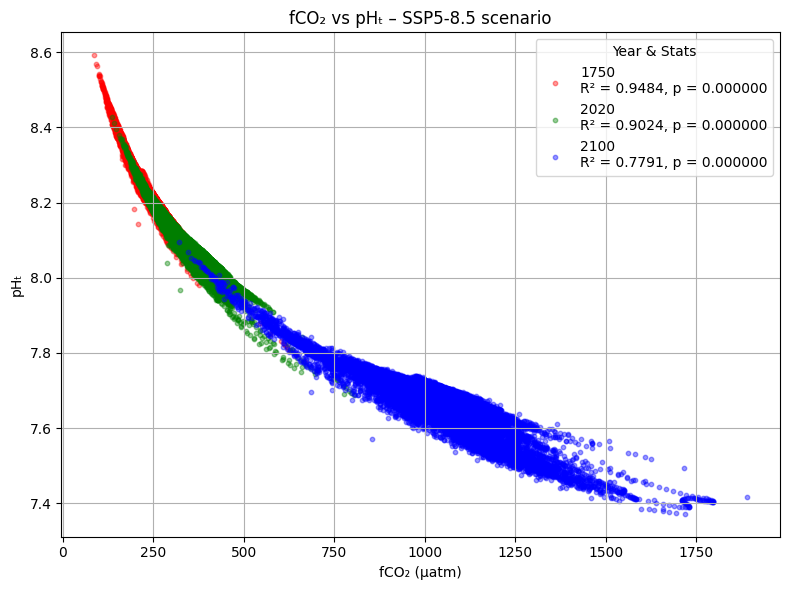

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# --------------------------------------------------
# 1.  Choose time slices (0‑based indices into ds.time)
# --------------------------------------------------
time_indices = [0, 18, 26]
colors       = ['red', 'green', 'blue']  # one colour per slice

# --------------------------------------------------
# 2.  Select the dataset (SSP5‑8.5 in this example)
# --------------------------------------------------
ds = historical_and_ssp585          # already in memory

# --------------------------------------------------
# 3.  Build the scatter plot
# --------------------------------------------------
plt.figure(figsize=(8, 6))

for idx, colour in zip(time_indices, colors):
    # Extract 2‑D fields at this time
    fCO2 = ds['fCO2'].isel(time=idx)
    pHT  = ds['pHT' ].isel(time=idx)

    # Flatten and mask NaNs
    fCO2_flat = fCO2.values.ravel()
    pHT_flat  = pHT .values.ravel()
    mask = ~np.isnan(fCO2_flat) & ~np.isnan(pHT_flat)

    # Linear regression
    slope, intercept, r_value, p_value, _ = linregress(fCO2_flat[mask], pHT_flat[mask])
    r_squared = r_value ** 2

    # Get a readable year label
    year_label = str(int(ds['time'].isel(time=idx).values))

    # Full-precision p-value formatting
    label = f"{year_label}\nR² = {r_squared:.4f}, p = {p_value:6f}"

    # Scatter
    plt.scatter(fCO2_flat[mask],
                pHT_flat [mask],
                s=10, alpha=0.4, color=colour,
                label=label)

# Plot cosmetics
plt.xlabel("fCO₂ (µatm)")
plt.ylabel("pHₜ")
plt.title("fCO₂ vs pHₜ – SSP5‑8.5 scenario")
plt.legend(title="Year & Stats", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


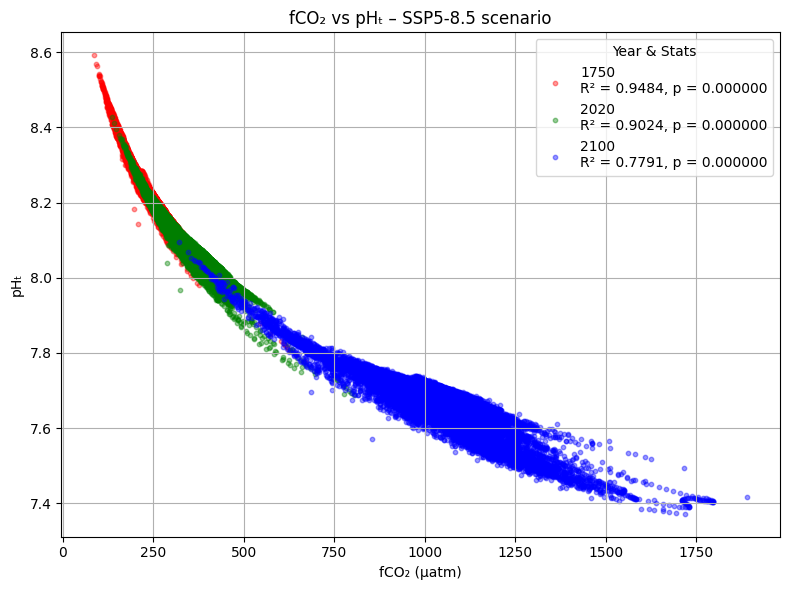

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# --------------------------------------------------
# 1.  Choose time slices (0‑based indices into ds.time)
# --------------------------------------------------
time_indices = [0, 18, 26]
colors       = ['red', 'green', 'blue']  # one colour per slice

# --------------------------------------------------
# 2.  Select the dataset (SSP5‑8.5 in this example)
# --------------------------------------------------
ds = historical_and_ssp585          # already in memory

# --------------------------------------------------
# 3.  Build the scatter plot
# --------------------------------------------------
plt.figure(figsize=(8, 6))

for idx, colour in zip(time_indices, colors):
    # Extract 2‑D fields at this time
    fCO2 = ds['fCO2'].isel(time=idx)
    pHT  = ds['pHT' ].isel(time=idx)

    # Flatten and mask NaNs
    fCO2_flat = fCO2.values.ravel()
    pHT_flat  = pHT .values.ravel()
    mask = ~np.isnan(fCO2_flat) & ~np.isnan(pHT_flat)

    # Linear regression
    slope, intercept, r_value, p_value, _ = linregress(fCO2_flat[mask], pHT_flat[mask])
    r_squared = r_value ** 2

    # Get a readable year label
    year_label = str(int(ds['time'].isel(time=idx).values))

    # Full-precision p-value formatting
    label = f"{year_label}\nR² = {r_squared:.4f}, p = {p_value:6f}"

    # Scatter
    plt.scatter(fCO2_flat[mask],
                pHT_flat [mask],
                s=10, alpha=0.4, color=colour,
                label=label)

# Plot cosmetics
plt.xlabel("fCO₂ (µatm)")
plt.ylabel("pHₜ")
plt.title("fCO₂ vs pHₜ – SSP5‑8.5 scenario")
plt.legend(title="Year & Stats", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


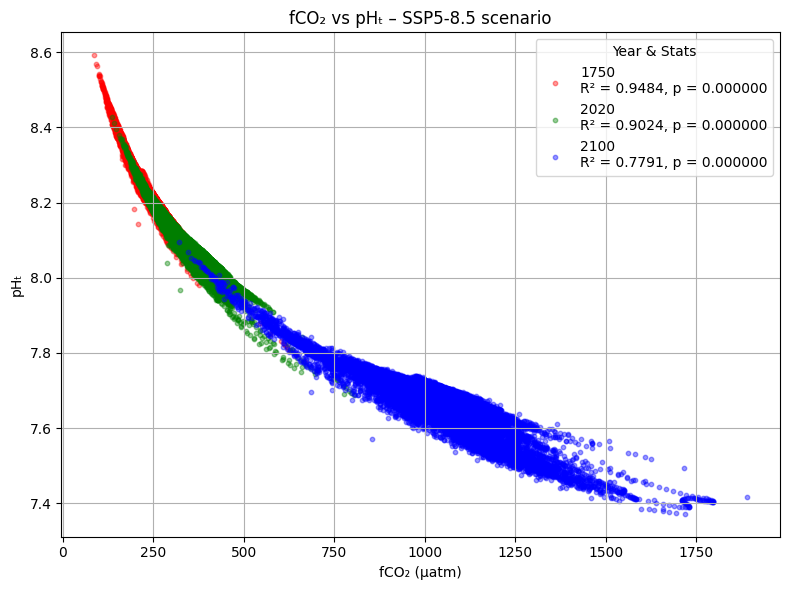

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# --------------------------------------------------
# 1.  Choose time slices (0‑based indices into ds.time)
# --------------------------------------------------
time_indices = [0, 18, 26]
colors       = ['red', 'green', 'blue']  # one colour per slice

# --------------------------------------------------
# 2.  Select the dataset (SSP5‑8.5 in this example)
# --------------------------------------------------
ds = historical_and_ssp585          # already in memory

# --------------------------------------------------
# 3.  Build the scatter plot
# --------------------------------------------------
plt.figure(figsize=(8, 6))

for idx, colour in zip(time_indices, colors):
    # Extract 2‑D fields at this time
    fCO2 = ds['fCO2'].isel(time=idx)
    pHT  = ds['pHT' ].isel(time=idx)

    # Flatten and mask NaNs
    fCO2_flat = fCO2.values.ravel()
    pHT_flat  = pHT .values.ravel()
    mask = ~np.isnan(fCO2_flat) & ~np.isnan(pHT_flat)

    # Linear regression
    slope, intercept, r_value, p_value, _ = linregress(fCO2_flat[mask], pHT_flat[mask])
    r_squared = r_value ** 2

    # Get a readable year label
    year_label = str(int(ds['time'].isel(time=idx).values))

    # Full-precision p-value formatting
    label = f"{year_label}\nR² = {r_squared:.4f}, p = {p_value:6f}"

    # Scatter
    plt.scatter(fCO2_flat[mask],
                pHT_flat [mask],
                s=10, alpha=0.4, color=colour,
                label=label)

# Plot cosmetics
plt.xlabel("fCO₂ (µatm)")
plt.ylabel("pHₜ")
plt.title("fCO₂ vs pHₜ – SSP5‑8.5 scenario")
plt.legend(title="Year & Stats", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


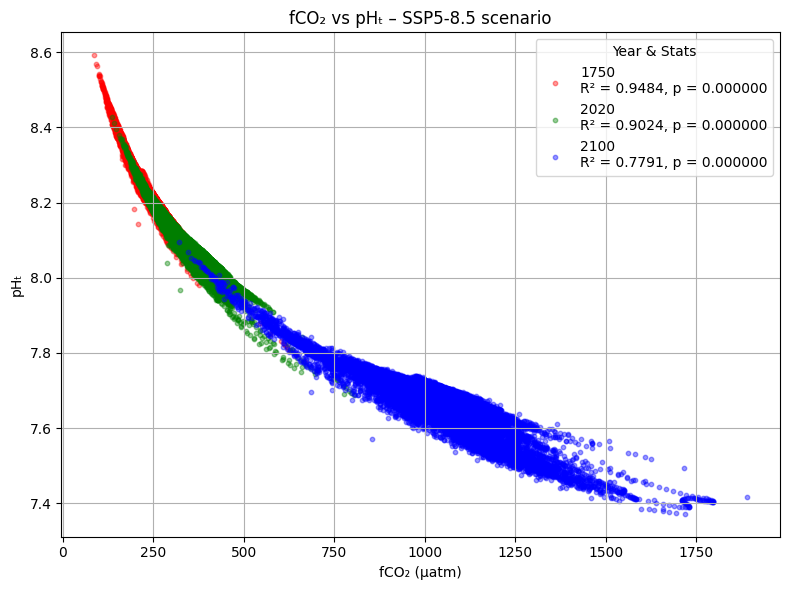

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# --------------------------------------------------
# 1.  Choose time slices (0‑based indices into ds.time)
# --------------------------------------------------
time_indices = [0, 18, 26]
colors       = ['red', 'green', 'blue']  # one colour per slice

# --------------------------------------------------
# 2.  Select the dataset (SSP5‑8.5 in this example)
# --------------------------------------------------
ds = historical_and_ssp585          # already in memory

# --------------------------------------------------
# 3.  Build the scatter plot
# --------------------------------------------------
plt.figure(figsize=(8, 6))

for idx, colour in zip(time_indices, colors):
    # Extract 2‑D fields at this time
    fCO2 = ds['fCO2'].isel(time=idx)
    pHT  = ds['pHT' ].isel(time=idx)

    # Flatten and mask NaNs
    fCO2_flat = fCO2.values.ravel()
    pHT_flat  = pHT .values.ravel()
    mask = ~np.isnan(fCO2_flat) & ~np.isnan(pHT_flat)

    # Linear regression
    slope, intercept, r_value, p_value, _ = linregress(fCO2_flat[mask], pHT_flat[mask])
    r_squared = r_value ** 2

    # Get a readable year label
    year_label = str(int(ds['time'].isel(time=idx).values))

    # Full-precision p-value formatting
    label = f"{year_label}\nR² = {r_squared:.4f}, p = {p_value:6f}"

    # Scatter
    plt.scatter(fCO2_flat[mask],
                pHT_flat [mask],
                s=10, alpha=0.4, color=colour,
                label=label)

# Plot cosmetics
plt.xlabel("fCO₂ (µatm)")
plt.ylabel("pHₜ")
plt.title("fCO₂ vs pHₜ – SSP5‑8.5 scenario")
plt.legend(title="Year & Stats", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-98-1068524357.py:146: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


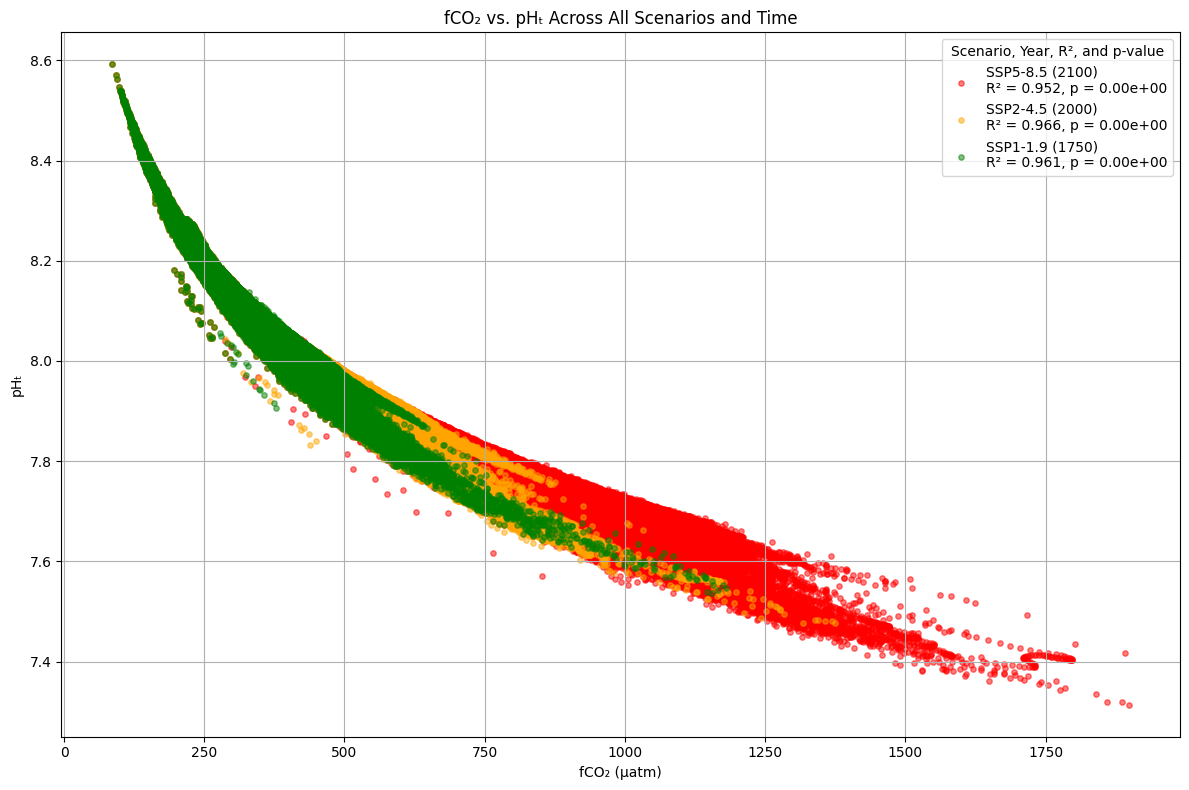

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os
import xarray as xr
from collections import defaultdict


def load_OCADS_data(directory="./"):
    """
    Load NetCDF files saved in `directory` into a nested dictionary of the form:
        output[variable][scenario] = xarray.DataArray

    Assumes files are named like: VARIABLE_SCENARIO.nc (e.g., pHT_historical.nc)

    Parameters:
        directory (str): Directory to search for NetCDF files.

    Returns:
        dict: Nested dictionary with structure [variable][scenario] = DataArray
    """
    output = defaultdict(dict)

    for fname in os.listdir(directory):
        if fname.endswith(".nc"):
            # Parse variable and scenario from filename
            base = os.path.splitext(fname)[0]  # Remove .nc
            try:
                var, scen = base.rsplit("_", 1)
            except ValueError:
                # Silently skip files that don't match the format
                continue
            path = os.path.join(directory, fname)
            ds = xr.open_dataset(path)
            if var in ds:
                output[var][scen] = ds[var]
            else:
                # fallback to the first variable if name not found explicitly
                output[var][scen] = next(iter(ds.data_vars.values()))

    return dict(output)


def combine_variables_per_scenario(output):
    """
    Combine variables for each scenario into a single xarray.Dataset.

    Parameters:
        output (dict): Nested dictionary structured as output[variable][scenario] = DataArray

    Returns:
        dict: Dictionary with keys = scenario names, values = xarray.Dataset containing all variables
    """
    combined = {}

    # Get all unique scenarios from any variable
    scenarios = set(s for var in output for s in output[var])

    for scenario in scenarios:
        vars_for_scenario = {
            var: output[var][scenario]
            for var in output
            if scenario in output[var]
        }
        if vars_for_scenario:
            combined[scenario] = xr.Dataset(vars_for_scenario)

    return combined


def concat_historical_with_ssp(combined_scenarios, ssp_scenario):
    """
    Concatenate the 'historical' and given SSP scenario Datasets along time.

    Parameters:
        combined_scenarios (dict): Output of combine_variables_per_scenario()
        ssp_scenario (str): Scenario to append to historical (e.g., 'ssp245', 'ssp585')

    Returns:
        xarray.Dataset: Combined Dataset with 'historical' followed by SSP scenario.
    """
    if 'historical' not in combined_scenarios:
        raise ValueError("Historical data not found in combined_scenarios. Check input files.")
    if ssp_scenario not in combined_scenarios:
        raise ValueError(f"Scenario '{ssp_scenario}' not found in combined_scenarios")

    return xr.concat(
        [combined_scenarios['historical'], combined_scenarios[ssp_scenario]],
        dim='time'
    )


# Load the data first
data = load_OCADS_data('./')
data_combined = combine_variables_per_scenario(data)
historical_and_ssp585 = concat_historical_with_ssp(data_combined, 'ssp585')
historical_and_ssp245 = concat_historical_with_ssp(data_combined, 'ssp245')
historical_and_ssp119 = concat_historical_with_ssp(data_combined, 'ssp119')

# --------------------------------------------------
# 1.  Define scenarios, colors, and specific years for the legend
# --------------------------------------------------
scenarios = {
    "SSP5-8.5": (historical_and_ssp585, 'red', 2100),
    "SSP2-4.5": (historical_and_ssp245, 'orange', 2000),
    "SSP1-1.9": (historical_and_ssp119, 'green', 1750)
}


# --------------------------------------------------
# 2.  Build the scatter plot
# --------------------------------------------------
plt.figure(figsize=(12, 8))

for name, (ds, colour, year) in scenarios.items():
    # Extract all time steps for the scenario
    fCO2 = ds['fCO2']
    pHT  = ds['pHT']

    # Flatten and mask NaNs
    fCO2_flat = fCO2.values.ravel()
    pHT_flat  = pHT.values.ravel()
    mask = ~np.isnan(fCO2_flat) & ~np.isnan(pHT_flat)

    # Compute R² and p-value
    slope, intercept, r_value, p_value, _ = linregress(fCO2_flat[mask], pHT_flat[mask])
    r_squared = r_value ** 2

    # Create a label with the scenario name, R², p-value, and the specified year
    label = f"{name} ({year})\nR² = {r_squared:.3f}, p = {p_value:.2e}"

    # Scatter plot
    plt.scatter(fCO2_flat[mask],
                pHT_flat[mask],
                s=15, alpha=0.5, color=colour,
                label=label)

# --------------------------------------------------
# 3.  Final plot cosmetics
# --------------------------------------------------
plt.xlabel("fCO₂ (µatm)")
plt.ylabel("pHₜ")
plt.title("fCO₂ vs. pHₜ Across All Scenarios and Time")
plt.legend(title="Scenario, Year, R², and p-value")
plt.grid(True)
plt.tight_layout()
plt.show()